# Plots for mutation-transmissibility paper

This notebook generates plots for the [paper/](paper/) directory. This assumes you've alread run
```sh
make update        # ~30 minutes on CPU (mostly sequence alignment)
python mutrans.py  # ~2 hours on GPU (mostly MCMC)
```

In [133]:
import datetime
import math
import pickle
import logging
from collections import Counter, OrderedDict, defaultdict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import torch
import pyro.distributions as dist
from pyrocov import mutrans, pangolin, stats
from pyrocov.stats import normal_log10bf

logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)
torch.set_default_dtype(torch.double)
matplotlib.rcParams["figure.dpi"] = 200
matplotlib.rcParams["axes.edgecolor"] = "gray"
# matplotlib.rcParams["axes.linewidth"] = 0.5
matplotlib.rcParams["lines.markeredgewidth"]
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Avenir', 'DejaVu Sans']

## Load data

In [68]:
%%time
dataset = mutrans.load_gisaid_data()
dataset.update(mutrans.load_jhu_data(dataset))
print(dataset.keys())
locals().update(dataset)
print(len(mutations))

 16434160 Loading data
 16434993 Training on 1425131 rows with columns:
 16434994 lineage, virus_name, accession_id, collection_date, location, add_location, day
 16436963 Partitioning the following countries into subregions: Australia, Belgium, Brazil, Canada, Denmark, France, Germany, India, Italy, Lithuania, Netherlands, Norway, Poland, Slovenia, South Africa, Spain, Sweden, Switzerland, USA, United Kingdom
 16437030 Loaded 1275 x 2251 feature matrix
 16450354 WARNING skipping unsampled lineage B.1.616
 16450774 WARNING skipping unsampled lineage AT.1
 16451436 WARNING skipping unsampled lineage B.1.617
 16453053 Keeping 1425078/1425131 rows (dropped 53)
 16453145 Keeping 1192/1783 regions
 16454010 Loaded 474 x 3617 daily case data, totaling 191034068.0
 16454010 Joining GISAID and JHU region codes
 16454249 Matching 1192 GISAID regions to 3617 JHU fuzzy regions


dict_keys(['location_id', 'mutations', 'weekly_strains', 'features', 'feature_order', 'feature_order_max', 'lineage_id', 'lineage_id_inv', 'local_time', 'daily_cases', 'weekly_cases'])
2251
CPU times: user 20.3 s, sys: 1.36 s, total: 21.7 s
Wall time: 20.3 s


In [69]:
print("{} x {} x {} = {}".format(*weekly_strains.shape, weekly_strains.shape.numel()))

38 x 1192 x 1275 = 57752400


In [70]:
with open("results/gisaid.columns.pkl", "rb") as f:
    columns = pickle.load(f)
print("Loaded data from {} samples".format(len(columns["lineage"])))

Loaded data from 1425131 samples


Sanity checking case count time series:

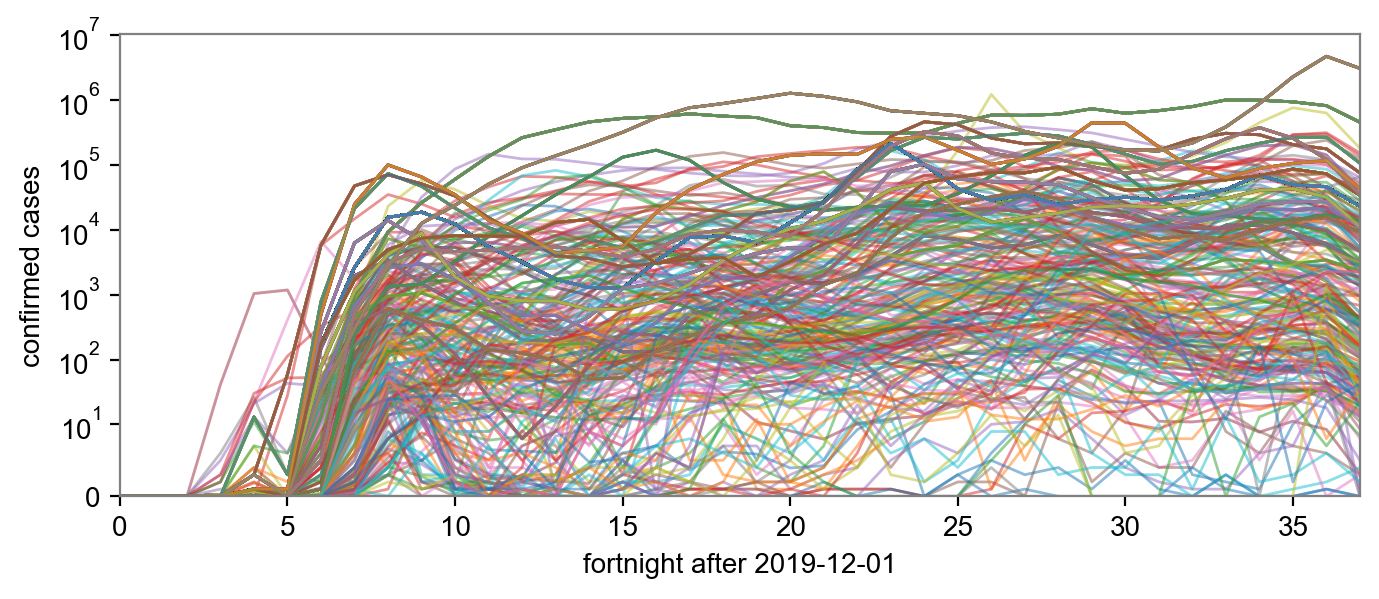

In [71]:
plt.figure(figsize=(8, 3))
plt.plot(weekly_cases, lw=1, alpha=0.5)
plt.yscale("symlog", linthresh=10)
plt.ylim(0, None)
plt.xlim(0, len(weekly_cases) - 1)
plt.xlabel("fortnight after 2019-12-01")
plt.ylabel("confirmed cases");

In [72]:
locations = set(location_id)
N_usa = sum(1 for k in locations if "/ USA /" in k)
N_uk = sum(1 for k in locations if "/ United Kingdom /" in k)
N_other = len(locations) - N_usa - N_uk
print(N_usa, N_uk, N_other)

55 4 1133


We'll account for epidemiological dynamics in the form of random drift on top of our logistic growth model. Since random drift is inversely proportional to the local number of infections, we'll need a new data source for the number of infections in each region. We'll use JHU's confirmed case counts time series as a proxy for the number of total infections in each region.

## Load trained models

In [135]:
fits = torch.load("results/mutrans.pt", map_location="cpu")

In [136]:
print(fits.keys())

dict_keys([('mvn_delta_dependent', 10001, 0.005, 0.1, ()), ('map', 2001, 0.01, 1.0, ()), ('mcmc', 'mvn_delta_dependent', 10001, 500, 500, 2, 10, ()), ('mvn_delta_dependent', 10001, 0.005, 0.1, (('include', (('location', '^North America / USA'),)),)), ('mcmc', 'mvn_delta_dependent', 10001, 500, 500, 2, 10, (('include', (('location', '^North America / USA'),)),)), ('mvn_delta_dependent', 10001, 0.005, 0.1, (('exclude', (('location', '^North America / USA'),)),)), ('mcmc', 'mvn_delta_dependent', 10001, 500, 500, 2, 10, (('exclude', (('location', '^North America / USA'),)),))])


In [137]:
svi_fit = [v for k, v in fits.items() if k[0] == "mvn_delta_dependent" if k[-1] == ()][0]
mcmc_fits = [v for k, v in fits.items() if k[0] == "mcmc"]
mcmc_fit, = [v for k, v in fits.items() if k[:2] == ("mcmc", "mvn_delta_dependent")
             if k[-1] == ()]
for key in fits:
    print(key)
print("SVI:", svi_fit.keys())
print("MCMC:", mcmc_fit.keys())
print(mcmc_fit["diagnostics"].keys())
print(mcmc_fit["diagnostics"]["rate_coef_aux"].keys())
print(mcmc_fit["median"].keys())
print(len(svi_fit["mutations"]))

('mvn_delta_dependent', 10001, 0.005, 0.1, ())
('map', 2001, 0.01, 1.0, ())
('mcmc', 'mvn_delta_dependent', 10001, 500, 500, 2, 10, ())
('mvn_delta_dependent', 10001, 0.005, 0.1, (('include', (('location', '^North America / USA'),)),))
('mcmc', 'mvn_delta_dependent', 10001, 500, 500, 2, 10, (('include', (('location', '^North America / USA'),)),))
('mvn_delta_dependent', 10001, 0.005, 0.1, (('exclude', (('location', '^North America / USA'),)),))
('mcmc', 'mvn_delta_dependent', 10001, 500, 500, 2, 10, (('exclude', (('location', '^North America / USA'),)),))
SVI: dict_keys(['median', 'mean', 'std', 'losses', 'params', 'walltime', 'args', 'mutations'])
MCMC: dict_keys(['losses', 'diagnostics', 'median', 'mean', 'std', 'samples', 'walltime', 'args', 'mutations'])
dict_keys(['concentration_aux', 'feature_scale_aux', 'rate_coef_aux', 'divergences', 'acceptance rate'])
odict_keys(['n_eff', 'r_hat'])
dict_keys(['concentration', 'feature_scale', 'rate_coef', 'init', 'rate'])
2251


Scale `rate_coef` by 1/100 in all results.

In [138]:
ALREADY_SCALED = set()

def scale_tensors(x, name="rate_coef", scale=0.01, prefix=""):
    if id(x) in ALREADY_SCALED:
        return
    if isinstance(x, dict):
        for k, v in list(x.items()):
            if k == name:
                print(f"{prefix}.{k}")
                x[k] = v * scale
            elif k == "diagnostics":
                continue
            else:
                scale_tensors(v, name, scale, f"{prefix}.{k}")
    ALREADY_SCALED.add(id(x))
                
scale_tensors(fits)

.('mvn_delta_dependent', 10001, 0.005, 0.1, ()).median.rate_coef
.('mvn_delta_dependent', 10001, 0.005, 0.1, ()).mean.rate_coef
.('mvn_delta_dependent', 10001, 0.005, 0.1, ()).std.rate_coef
.('map', 2001, 0.01, 1.0, ()).median.rate_coef
.('map', 2001, 0.01, 1.0, ()).mean.rate_coef
.('map', 2001, 0.01, 1.0, ()).std.rate_coef
.('mcmc', 'mvn_delta_dependent', 10001, 500, 500, 2, 10, ()).median.rate_coef
.('mcmc', 'mvn_delta_dependent', 10001, 500, 500, 2, 10, ()).mean.rate_coef
.('mcmc', 'mvn_delta_dependent', 10001, 500, 500, 2, 10, ()).std.rate_coef
.('mcmc', 'mvn_delta_dependent', 10001, 500, 500, 2, 10, ()).samples.rate_coef
.('mvn_delta_dependent', 10001, 0.005, 0.1, (('include', (('location', '^North America / USA'),)),)).median.rate_coef
.('mvn_delta_dependent', 10001, 0.005, 0.1, (('include', (('location', '^North America / USA'),)),)).mean.rate_coef
.('mvn_delta_dependent', 10001, 0.005, 0.1, (('include', (('location', '^North America / USA'),)),)).std.rate_coef
.('mcmc', 'mvn_de


## Assess model fitness

/Users/fobermey/opt/miniconda3/envs/pyro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/fobermey/opt/miniconda3/envs/pyro/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


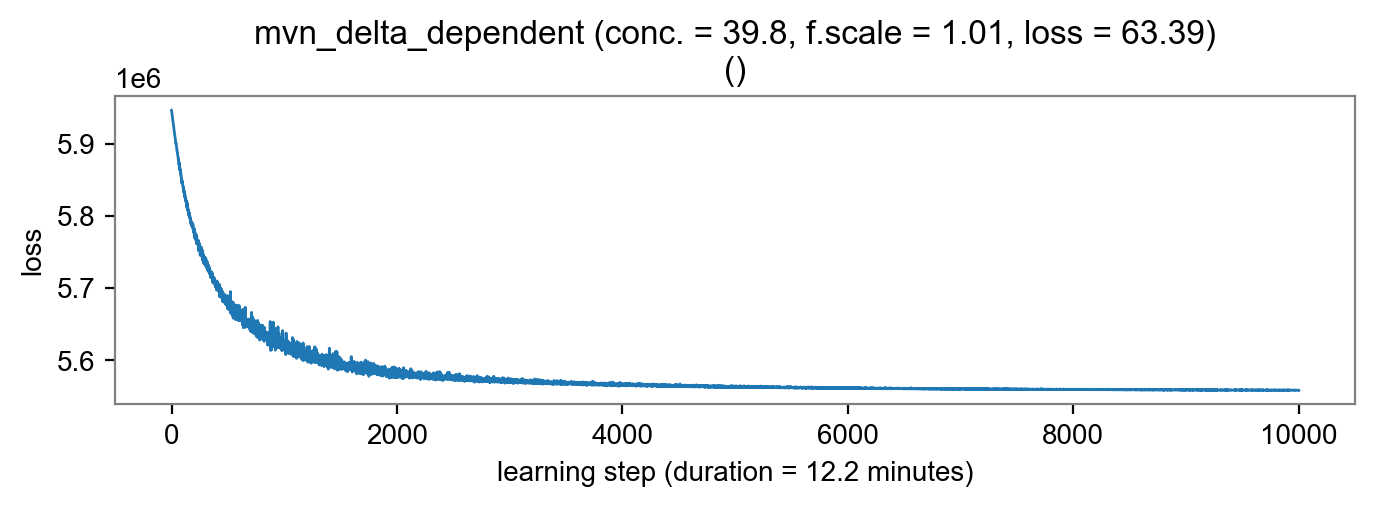

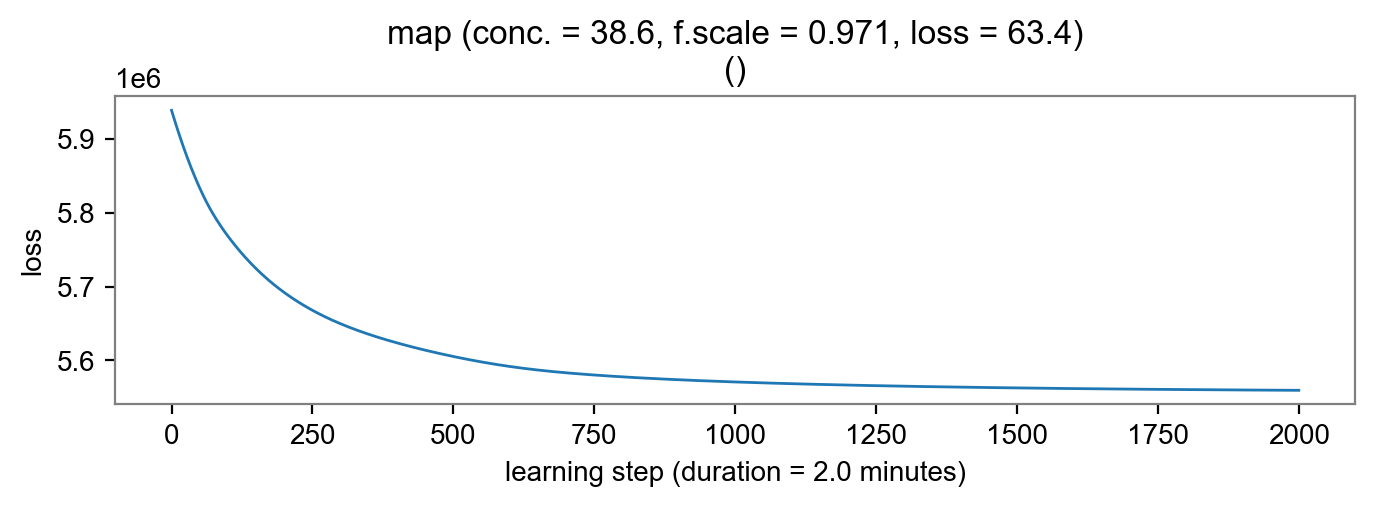

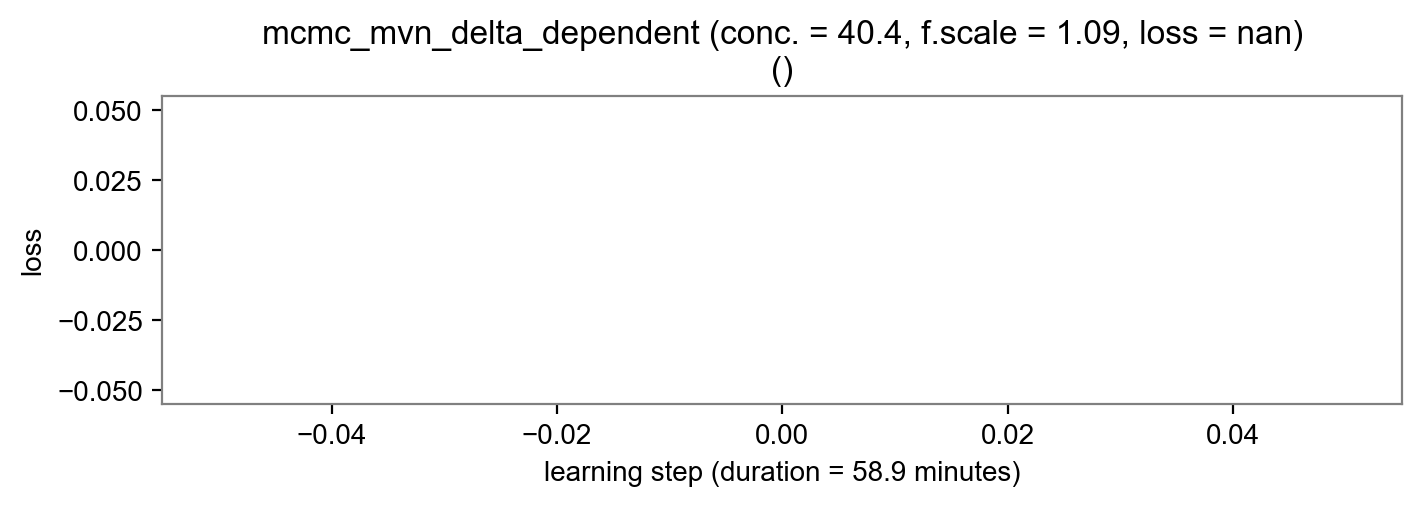

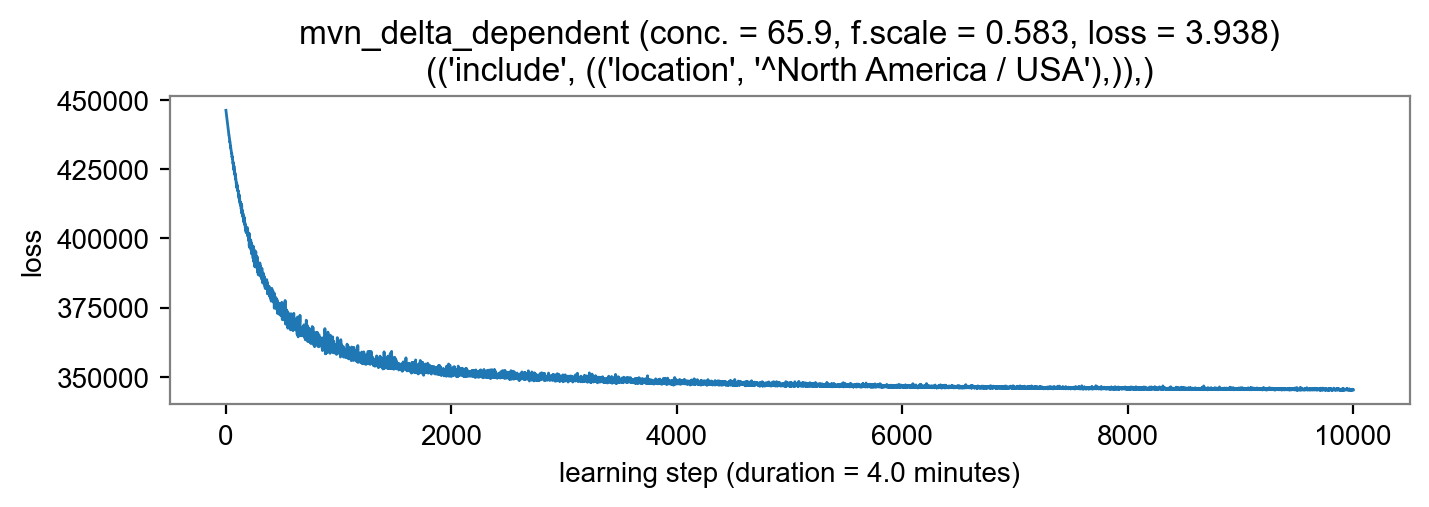

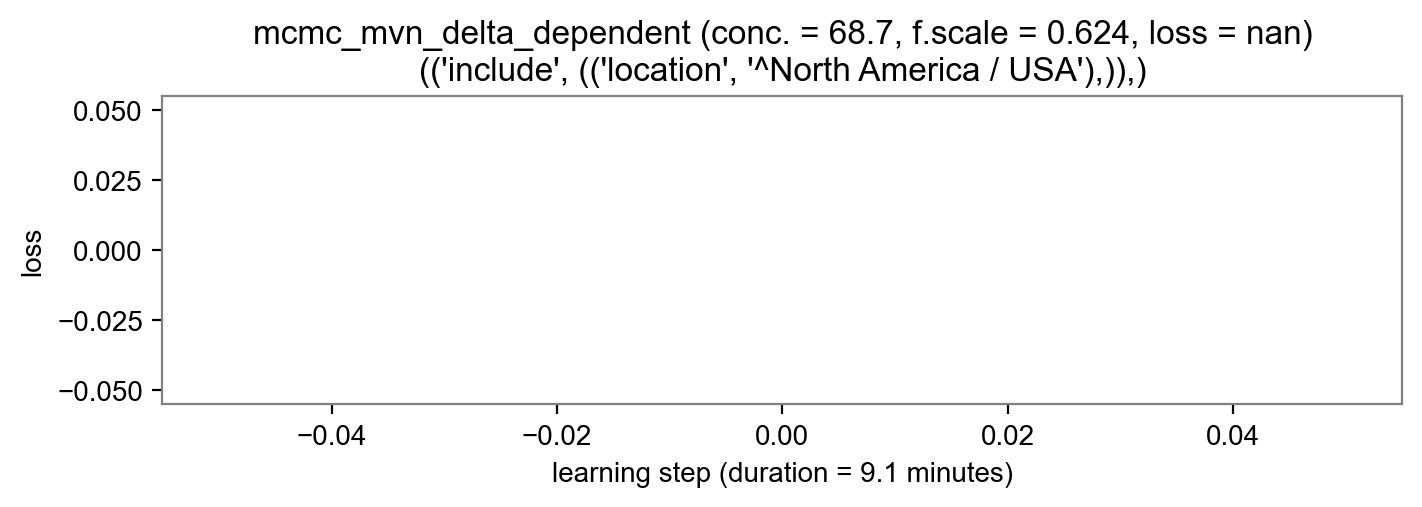

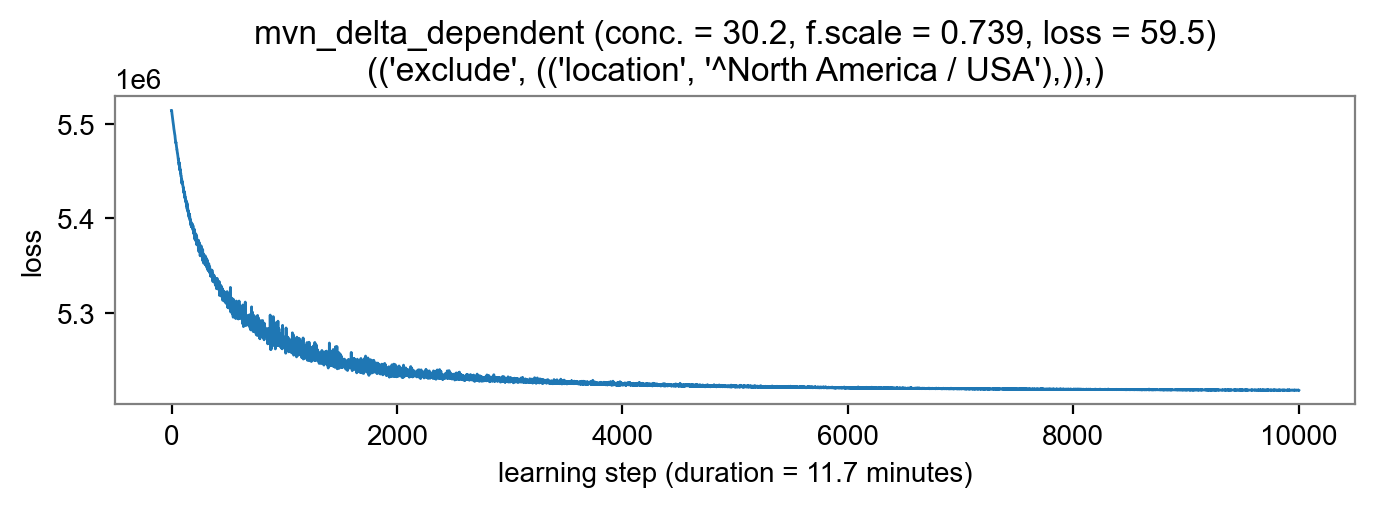

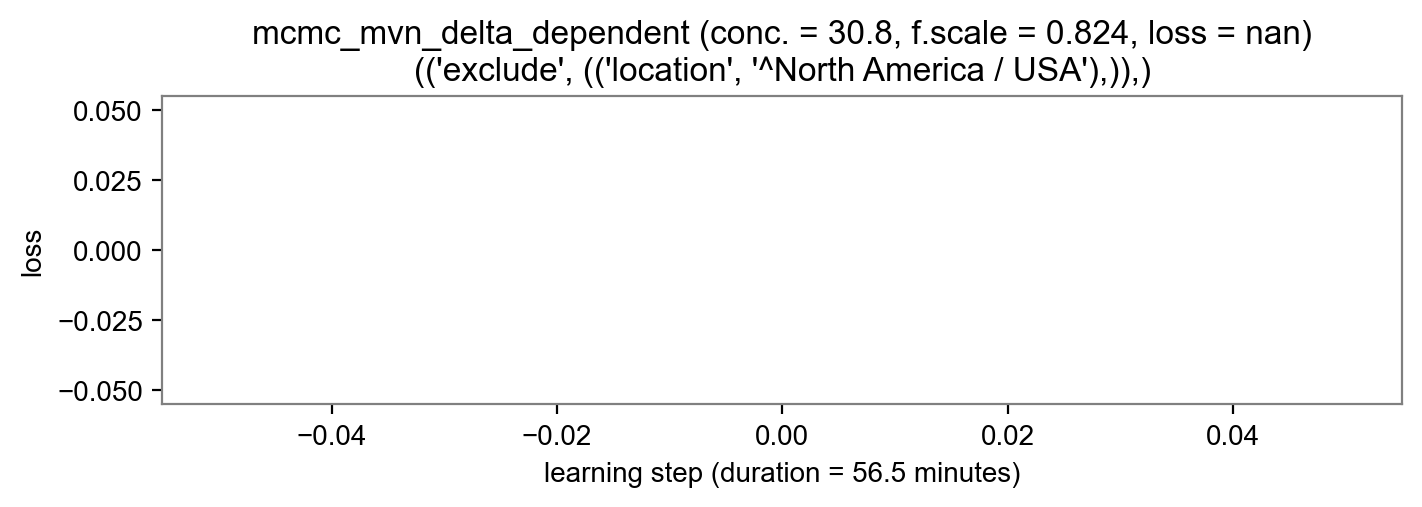

In [139]:
num_nonzero = int(torch.count_nonzero(weekly_strains))
for key, value in fits.items():
    median = value["median"]
    plt.figure(figsize=(8, 2))
    plt.plot(value["losses"], lw=1)
    plt.xlabel("learning step (duration = {:0.1f} minutes)".format(value["walltime"]/60))
    plt.ylabel("loss")
    plt.title("{} (conc. = {:0.3g}, f.scale = {:0.3g}, loss = {:0.4g})\n{}".format(
        key[0] + "_" + key[1] if key[0] == "mcmc" else key[0],
        median["concentration"].item(),
        median["feature_scale"].item(),
        np.median(value["losses"][-201:]) / num_nonzero,
        key[-1],
    ));

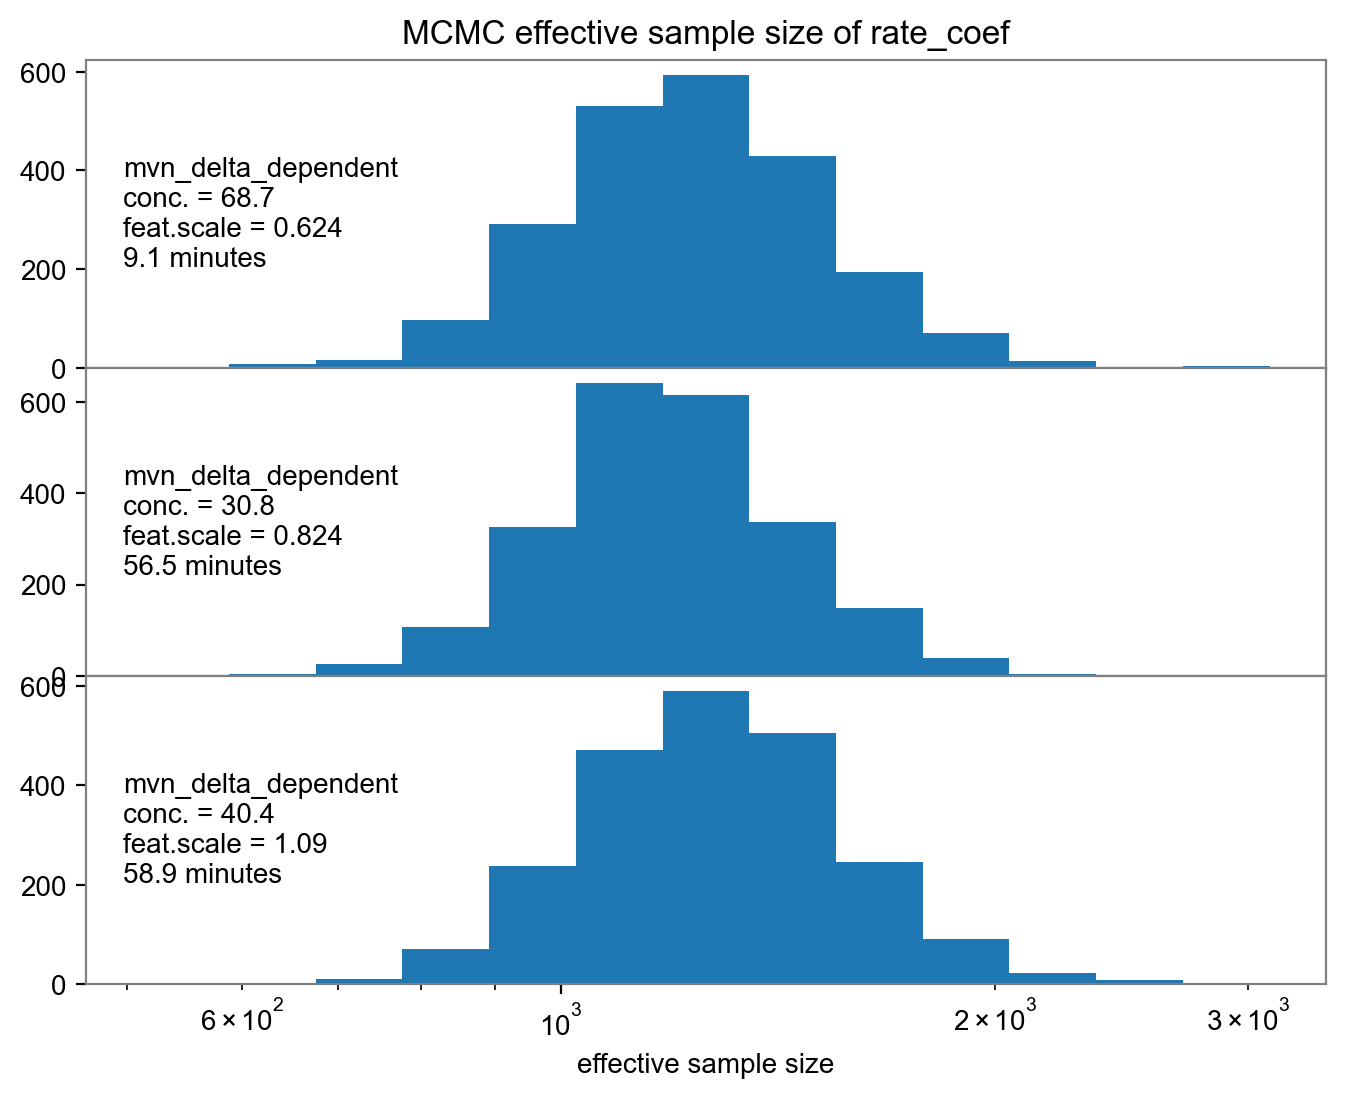

In [140]:
mcmc_fits = []
for key, fit in fits.items():
    if key[0] != "mcmc":
        continue
    d = fit["diagnostics"]
    n_eff = d.get("rate_coef", d.get("rate_coef_aux"))["n_eff"]
    mcmc_fits.append((key[1], n_eff, fit))
mcmc_fits.sort(key=lambda x: x[-1]["walltime"])
fig, axes = plt.subplots(len(mcmc_fits), 1, sharex=True, figsize=(8, 3 + len(mcmc_fits)))
if len(mcmc_fits) == 1:
    axes = [axes]
for (config, n_eff, fit), ax in zip(mcmc_fits, axes):
    walltime = fit["walltime"]
    feature_scale = float(fit["median"]["feature_scale"])
    concentration = float(fit["median"]["concentration"])
    if torch.isnan(n_eff).any():
        print("ERROR n_eff is NAN")
        continue
    base = 2 ** 0.2
    bins = [base ** i for i in range(int(n_eff.log().min() / math.log(base)),
                                     int(n_eff.log().max() / math.log(base)) + 2)]
    ax.hist(n_eff.numpy(), bins=bins)
    ax.set_xscale("log")
    ax.text(0.03, 0.5,
            "{}\nconc. = {:0.3g}\nfeat.scale = {:0.3g}\n{:0.1f} minutes".format(
                config, concentration, feature_scale, walltime / 60.0
            ),
            transform=ax.transAxes, verticalalignment="center")
axes[0].set_title("MCMC effective sample size of rate_coef")
axes[-1].set_xlabel("effective sample size")
plt.subplots_adjust(hspace=0);

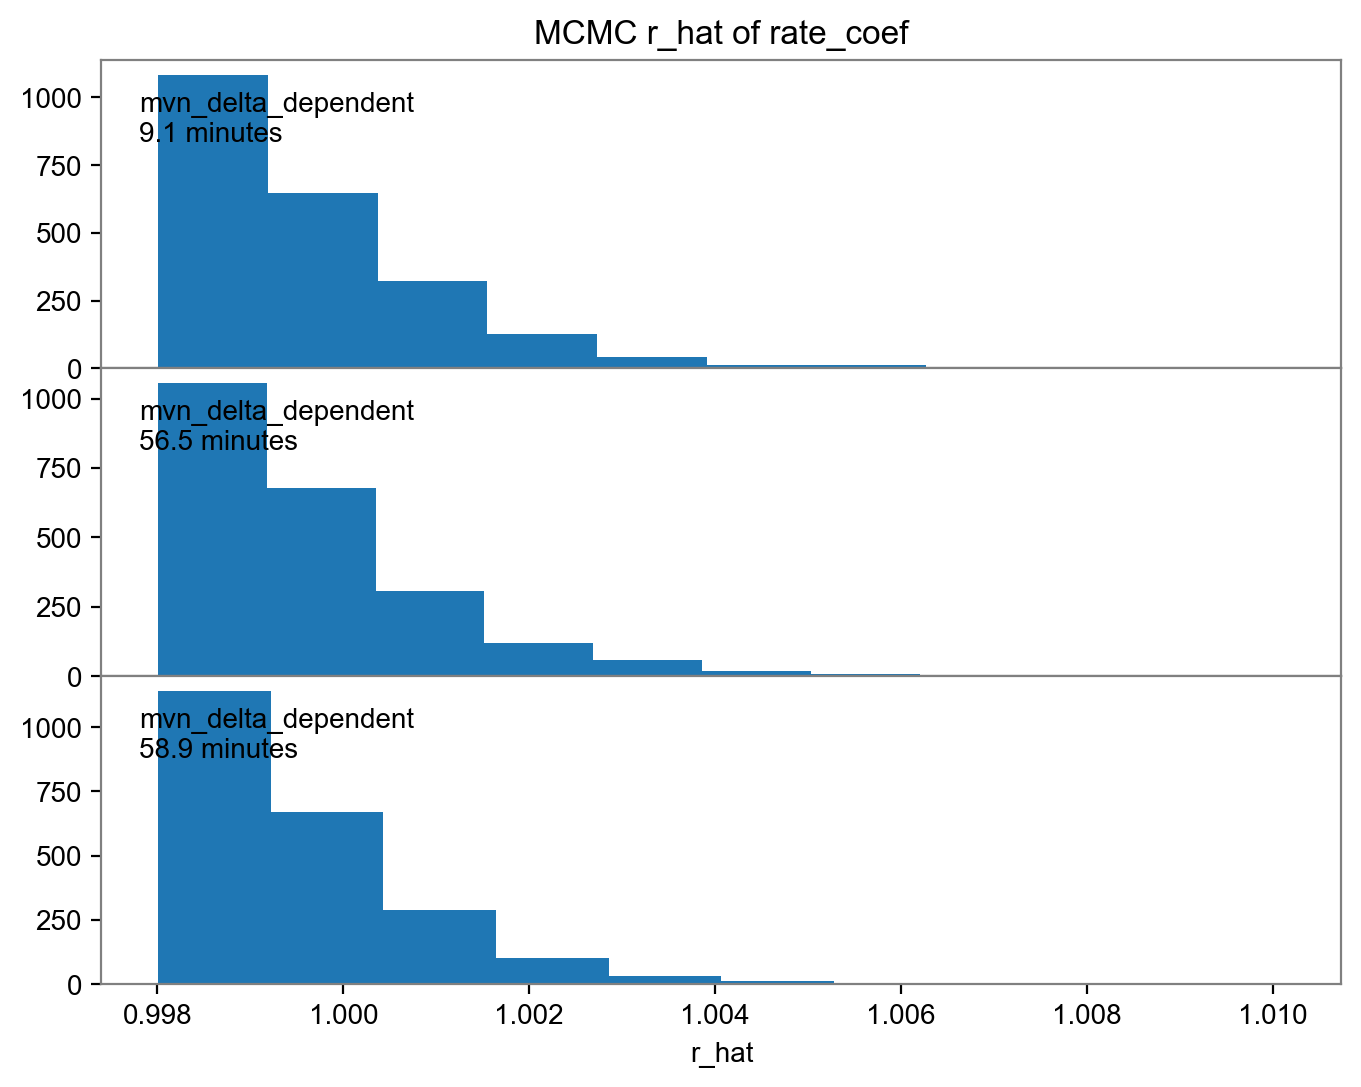

In [141]:
mcmc_fits = []
for key, fit in fits.items():
    if key[0] != "mcmc":
        continue
    d = fit["diagnostics"]
    r_hat = d.get("rate_coef", d.get("rate_coef_aux"))["r_hat"]
    mcmc_fits.append((key[1], r_hat, fit["walltime"]))
mcmc_fits.sort(key=lambda x: x[-1])
fig, axes = plt.subplots(len(mcmc_fits), 1, sharex=True, figsize=(8, 3 + len(mcmc_fits)))
if len(mcmc_fits) == 1:
    axes = [axes]
for (config, r_hat, walltime), ax in zip(mcmc_fits, axes):
    if torch.isnan(r_hat).any():
        print("ERROR r_hat is NAN")
        continue
    ax.hist(r_hat.numpy())
    ax.text(0.03, 0.9, "{}\n{:0.1f} minutes".format(config, walltime / 60.0),
            transform=ax.transAxes, verticalalignment="top")
axes[0].set_title("MCMC r_hat of rate_coef")
axes[-1].set_xlabel("r_hat")
plt.subplots_adjust(hspace=0);

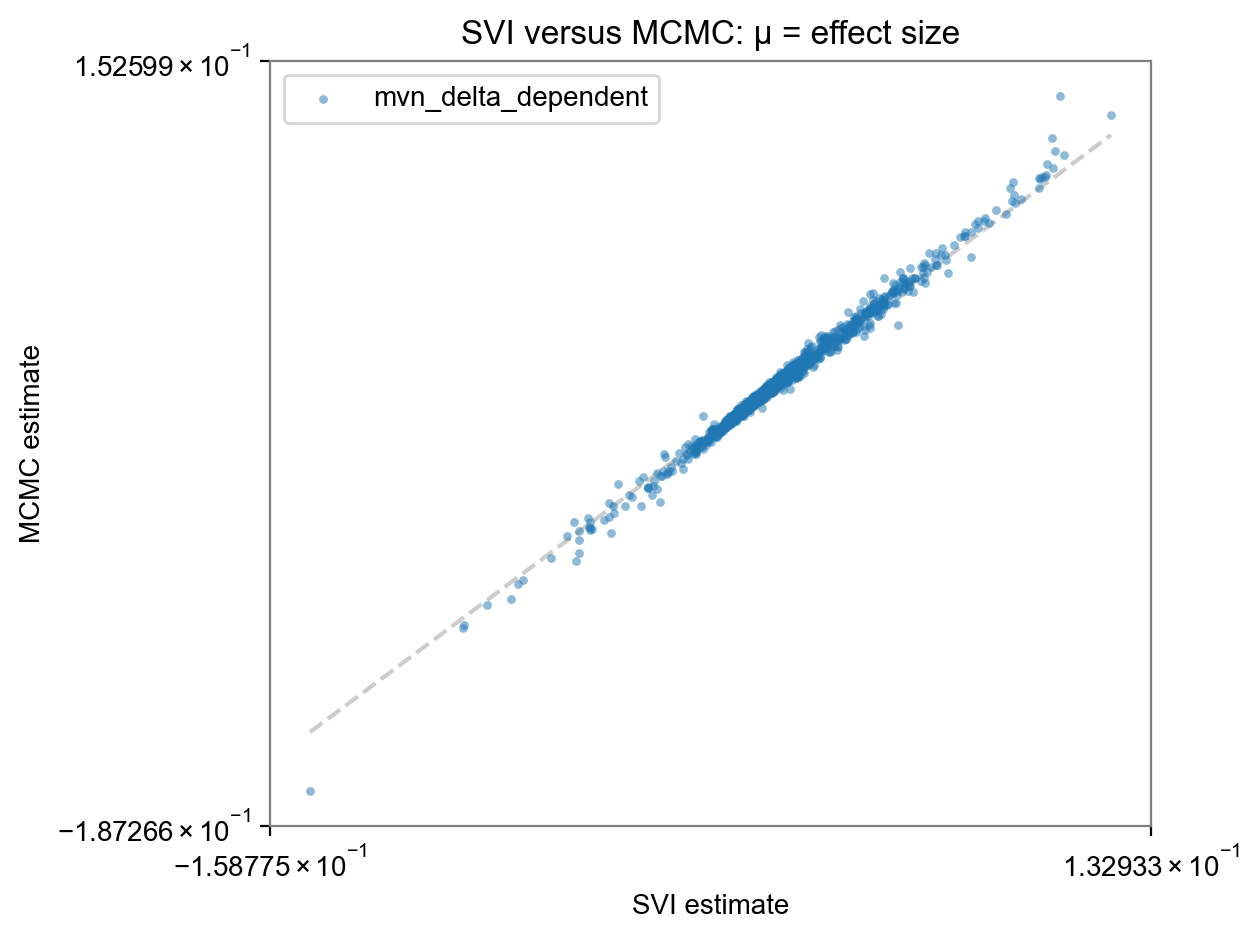

In [142]:
def plot_svi_mcmc_mean():
    x0 = svi_fit["mean"]["rate_coef"].min().item()
    x1 = svi_fit["mean"]["rate_coef"].max().item()
    plt.plot([x0, x1], [x0, x1], 'k--', alpha=0.2, zorder=-100)
    for key, fit in fits.items():
        if key[0] != "mcmc" or key[-1]:
            continue
        plt.scatter(
            svi_fit["mean"]["rate_coef"].numpy(),
            fit["mean"]["rate_coef"].numpy(),
            10, lw=0, alpha=0.5, label=key[1]
        )
    plt.xscale("symlog")
    plt.yscale("symlog")
    plt.title("SVI versus MCMC: μ = effect size")
    plt.xlabel("SVI estimate")
    plt.ylabel("MCMC estimate")
    plt.legend(loc="upper left")
    plt.tight_layout()
    
plot_svi_mcmc_mean()

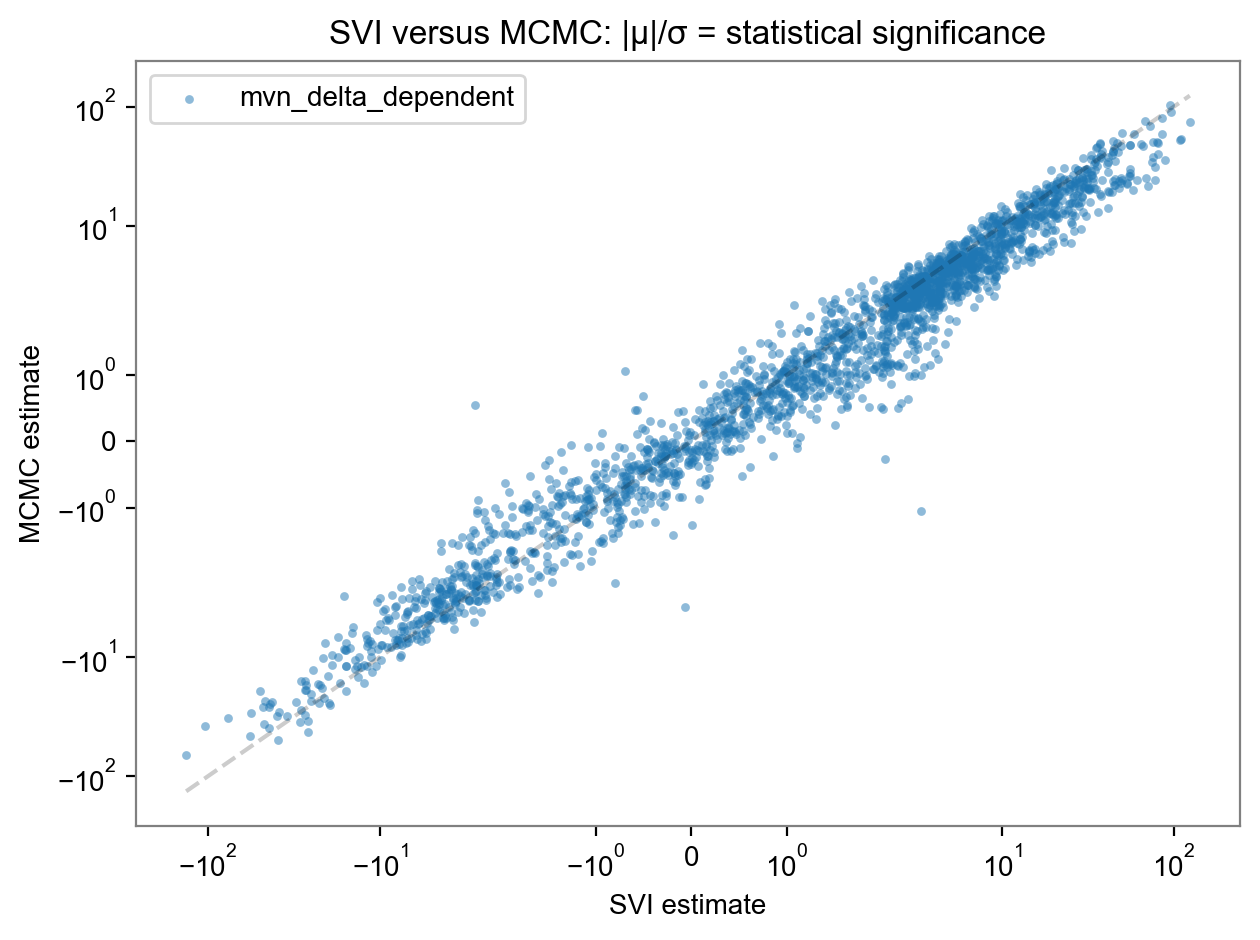

In [143]:
def plot_svi_mcmc_sigma():
    svi_sigma = svi_fit["mean"]["rate_coef"] / svi_fit["std"]["rate_coef"]
    x0 = svi_sigma.min().item()
    x1 = svi_sigma.max().item()
    plt.plot([x0, x1], [x0, x1], 'k--', alpha=0.2)
    for key, fit in fits.items():
        if key[0] != "mcmc" or key[-1]:
            continue
        mcmc_sigma = fit["mean"]["rate_coef"] / fit["std"]["rate_coef"]
        plt.scatter(svi_sigma.numpy(), mcmc_sigma.numpy(), 10, lw=0, alpha=0.5, label=key[1])
    plt.xscale("symlog")
    plt.yscale("symlog")
    plt.title("SVI versus MCMC: |μ|/σ = statistical significance")
    plt.xlabel("SVI estimate")
    plt.ylabel("MCMC estimate")
    plt.legend(loc="upper left")
    plt.tight_layout()
    
plot_svi_mcmc_sigma()

## Interpreting results

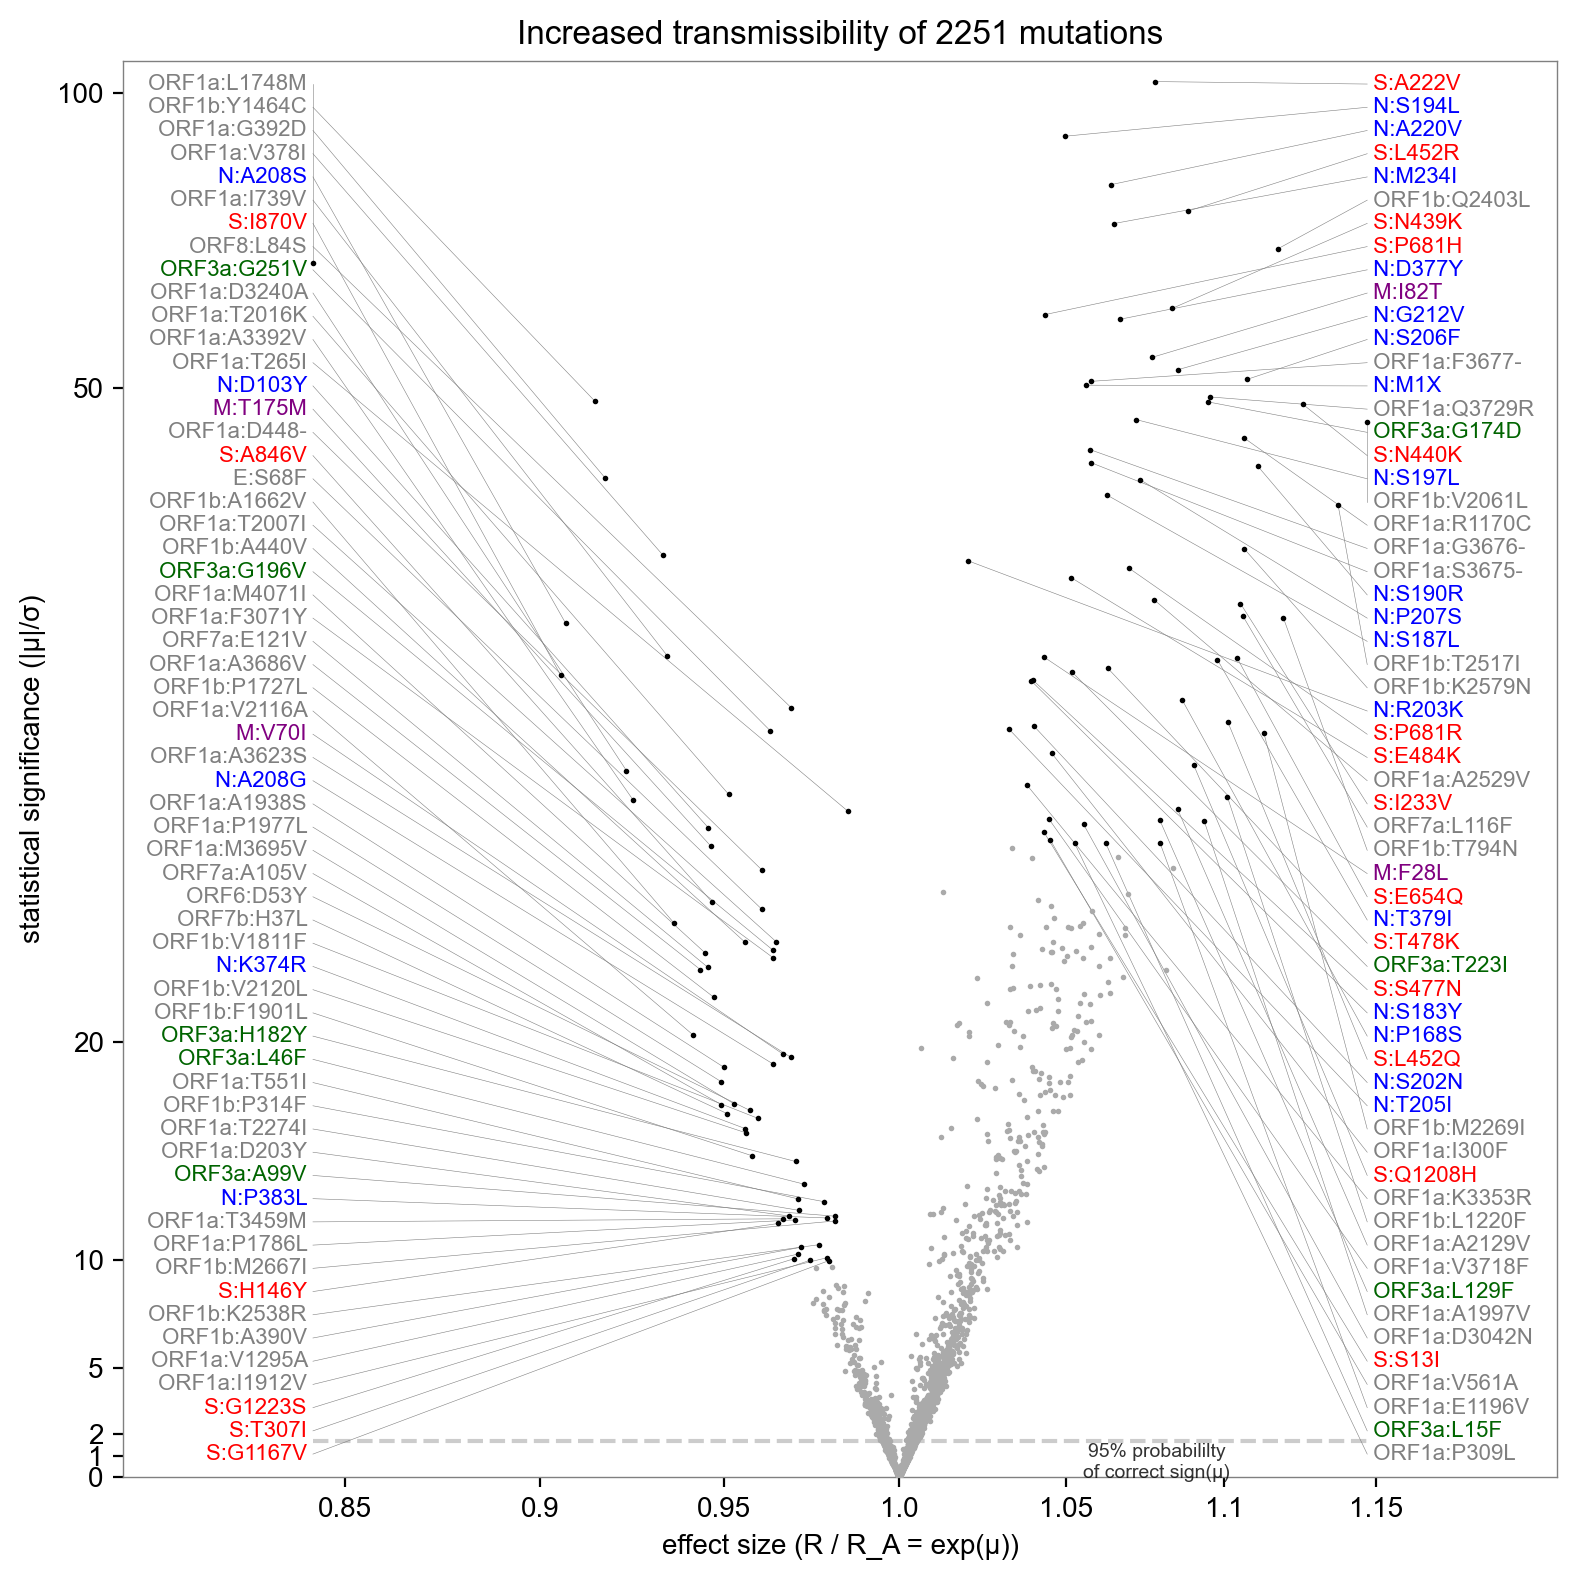

In [144]:
def plot_volcano(mean, std, filenames=(), linthresh=2, top_k=60):
    xs = mean
    ys = mean.abs() / std
    assert len(xs) == len(mutations)
    y0, y1 = float(ys.min()), float(ys.max())
    x0, x1 = float(xs.min()), float(xs.max())
    ys, idx = ys.sort(0, descending=True)
    xs = xs[idx]
    pos = (0 < xs) & (xs < math.inf)
    neg = (-math.inf < xs) & (xs < 0)
    ys_pos, ys_neg = ys[pos], ys[neg]
    xs_pos, xs_neg = xs[pos], xs[neg]
    idx_pos, idx_neg = idx[pos], idx[neg]
    N = top_k

    plt.figure(figsize=(8, 8))
    plt.title(f"Increased transmissibility of {len(mutations)} mutations")
    for mask in [pos, neg]:
        xs_mask, ys_mask = xs[mask], ys[mask]
        plt.plot(xs_mask[:N], ys_mask[:N], 'k.', lw=0, markersize=2, zorder=10)
        plt.plot(xs_mask[N:], ys_mask[N:], 'k.', lw=0, markersize=2, zorder=10, color="#aaa")
    plt.xlabel("effect size (R / R_A = exp(μ))")
    xticks = [0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15]
    plt.xticks(list(map(math.log, xticks)), list(map(str, xticks)))
    plt.ylabel("statistical significance (|μ|/σ)")
    lpad = 0.33 if any("," in mutations[i] for i in idx_neg[:N].tolist()) else 0.18
    rpad = 0.33 if any("," in mutations[i] for i in idx_pos[:N].tolist()) else 0.18
    plt.xlim(x0 - (x1 - x0) * lpad, x1 + (x1 - x0) * rpad)
    plt.ylim(0, None)
    plt.yscale("symlog", linthresh=linthresh)
    yticks = [y for y in [0, 1, 2, 5, 10, 20, 50, 100] if y < y1]
    plt.yticks(yticks, list(map(str, yticks)))
    p95 = dist.Normal(0, 1).icdf(torch.tensor(0.95)).item()
    plt.plot([x0, x1], [p95, p95], 'k--', alpha=0.2)
    plt.text(0.2 * x0 + 0.8 * x1, p95 * 0.95, "95% probabililty\nof correct sign(μ)",
             fontsize=7, horizontalalignment="center", verticalalignment="top",
             alpha=0.8, zorder=100)
        
    colors = {"N": "blue", "S": "red", "M": "purple", "ORF3a": "darkgreen"}
    ax = plt.gca()
    t = (ax.transScale + ax.transLimits).inverted()
    for i in range(N):
        x = x0
        _, y = t.transform((0, 1 - (i + 1) / (N + 1)))
        plt.plot([x, xs_neg[i]], [y, ys_neg[i]], color='gray', lw=0.2)
        name = mutations[int(idx_neg[i])]
        plt.text(x, y, name + " ", color=colors.get(name.split(":")[0], "gray"),
                 fontsize=8, verticalalignment="center", horizontalalignment="right")
    for i in range(N):
        x = x1
        _, y = t.transform((0, 1 - (i + 1) / (N + 1)))
        name = mutations[int(idx_pos[i])]
        plt.plot([x, xs_pos[i]], [y, ys_pos[i]], color='gray', lw=0.2)
        plt.text(x, y, " " + name, color=colors.get(name.split(":")[0], "gray"),
                 fontsize=8, verticalalignment="center", horizontalalignment="left")
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
    plt.tight_layout()
    for f in filenames:
        plt.savefig(f)

# plot_volcano(svi_fit["mean"]["rate_coef"], svi_fit["std"]["rate_coef"], linthresh=10)
plot_volcano(mcmc_fit["mean"]["rate_coef"], mcmc_fit["std"]["rate_coef"], linthresh=50,
             filenames=["paper/volcano.png"])

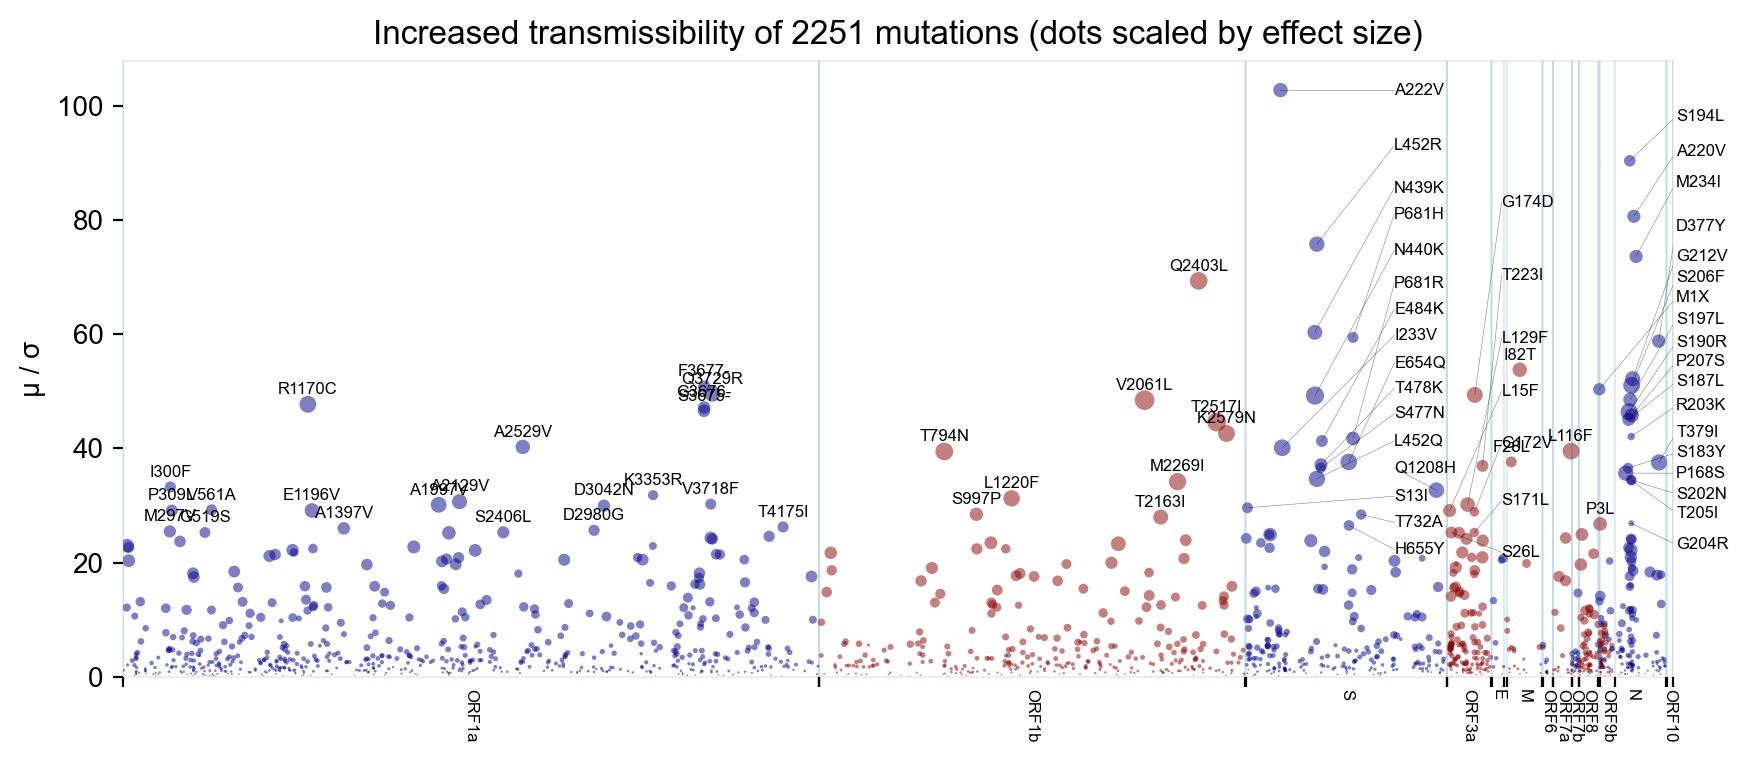

In [145]:
from pyrocov.sarscov2 import GENE_TO_POSITION, aa_mutation_to_position

def plot_manhattan(mean, std, top_k=75, filenames=()):
    sigma = mean / std.clamp(min=1e-8)
    y1 = sigma.max().item()
    position = torch.tensor([aa_mutation_to_position(m) for m in mutations])
    assert len(mean) == len(mutations)
    gene_id = {gene_name: i for i, gene_name in enumerate(GENE_TO_POSITION)}
    gene_ids = torch.tensor([gene_id[m.split(":")[0]] for m in mutations])
    even = (gene_ids % 2 == 0) & (mean > 0)
    odd = (gene_ids % 2 == 1) & (mean > 0)

    plt.figure(figsize=(10, 4))
    plt.title(f"Increased transmissibility of {len(mutations)} mutations"
              " (dots scaled by effect size)")
    mean_scale = 50 / mean.max().item()
    for mask, color in zip([even, odd], ["darkblue", "darkred"]):
        plt.scatter(position[mask].numpy(), sigma[mask].numpy(),
                    mean_scale * mean[mask].numpy(), color=color, alpha=0.5, lw=0)
    special = {"S": [], "N": [], "ORF3a": []}  # Many hits, plot with lines
    for i in sigma.sort(0, descending=True).indices[:top_k].tolist():
        x = float(position[i])
        y = float(sigma[i])
        gene, name = mutations[i].split(":")
        if gene in special:
            special[gene].append((y, x, name))
            continue
        plt.text(x, y + y1/80, name, fontsize=6,
                 verticalalignment="bottom", horizontalalignment="center")
    for special_ in special.values():
        special_.sort(reverse=True)
    y_bounds = {k: (min(y for (y, _, _) in v), max(y for (y, _, _) in v))
                for k, v in special.items() if v}
    for i, (y, x, name) in enumerate(special["S"]):
        lb, ub = y_bounds["S"]
        lb, ub = lb * 0.8, ub * 0.1 + y1 * 0.9
        y_label = 0.2 * y + 0.8 * (ub + (lb - ub) * (i / (len(special["S"]) - 0.99)))
        x_label = GENE_TO_POSITION["S"][1] - 1000
        plt.text(x_label, y_label, name, fontsize=6,
                 verticalalignment="center", horizontalalignment="left")
        plt.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
    for gene in ["N", "ORF3a"]:
        for i, (y, x, name) in enumerate(special[gene]):
            lb, ub = y_bounds[gene]
            lb, ub = lb * 0.8, ub * 0.1 + y1 * 0.9
            y_label = 0.3 * y + 0.7 * (ub + (lb - ub) * (i / (len(special[gene]) - 0.99)))
            x_label = GENE_TO_POSITION[gene][1] + 200
            plt.text(x_label, y_label, name, fontsize=6,
                     verticalalignment="center", horizontalalignment="left")
            plt.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
        
    start_end = list(GENE_TO_POSITION.values())
    plt.xlim(start_end[0][0], start_end[-1][-1])
    xticks = []
    for i, (gene, (start, end)) in enumerate(GENE_TO_POSITION.items()):
        if gene == "ORF14":
            continue  # skip overlapping frame
        plt.axvline(start, lw=0.1)
        plt.axvline(end, lw=0.1)
        xticks.extend([start, end])
        plt.text((start + end) / 2, -y1 / 50, gene, rotation=-90,
                 fontsize=6, verticalalignment="top", horizontalalignment="center")
    plt.xticks(xticks, labels=())
    plt.ylim(0, None)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(0.1)
    plt.ylabel("μ / σ")
    for f in filenames:
        plt.savefig(f)

# plot_manhattan(svi_fit["mean"]["rate_coef"], svi_fit["std"]["rate_coef"])
plot_manhattan(mcmc_fit["mean"]["rate_coef"], mcmc_fit["std"]["rate_coef"],
               filenames=["paper/manhattan.png"])

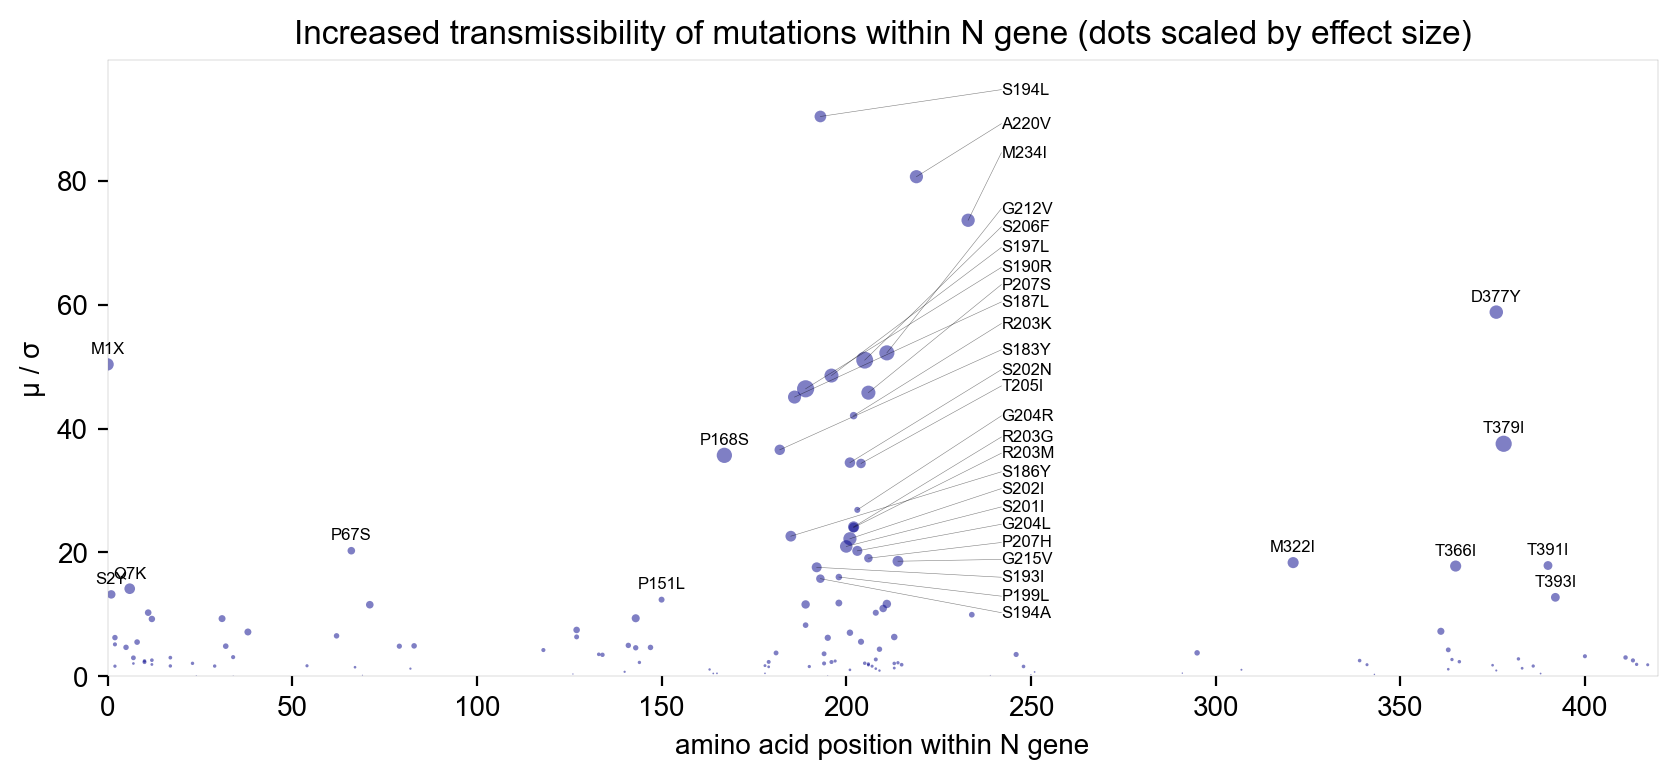

In [146]:
def plot_upper_east_side(mean, std, top_k=120, filenames=()):
    sigma = mean / std.clamp(min=1e-8)
    y1 = sigma.max().item()
    position = torch.tensor([aa_mutation_to_position(m) for m in mutations])
    assert len(mean) == len(mutations)
    gene_id = {gene_name: i for i, gene_name in enumerate(GENE_TO_POSITION)}
    gene_ids = torch.tensor([gene_id[m.split(":")[0]] for m in mutations])
    mask = (gene_ids == gene_id["N"]) & (mean > 0)

    plt.figure(figsize=(10, 4))
    plt.title(f"Increased transmissibility of mutations within N gene"
              " (dots scaled by effect size)")
    mean_scale = 50 / mean.max().item()
    plt.scatter(position[mask].numpy(), sigma[mask].numpy(),
                mean_scale * mean[mask].numpy(), color="darkblue", alpha=0.5, lw=0)
    special = []  # Many hits, plot with lines
    z0 = 28800
    z1 = 29000
    for i in sigma.sort(0, descending=True).indices[:top_k].tolist():
        x = float(position[i])
        y = float(sigma[i])
        gene, name = mutations[i].split(":")
        if gene != "N":
            continue
        if z0 < x < z1:
            special.append((y, x, name))
        else:
            plt.text(x, y + y1/80, name, fontsize=6,
                     verticalalignment="bottom", horizontalalignment="center")
    special.sort(reverse=True)
    lb = min(y for (y, _, _) in special)
    ub = max(y for (y, _, _) in special)
    lb, ub = lb * 0.5, ub * 0.5 + y1 * 0.5
    for i, (y, x, name) in enumerate(special):
        y_label = 0.3 * y + 0.7 * (ub + (lb - ub) * (i / (len(special) - 0.99)))
        x_label = z1
        plt.text(x_label, y_label, name, fontsize=6,
                 verticalalignment="center", horizontalalignment="left")
        plt.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
    start, end = GENE_TO_POSITION["N"]
    plt.xlim(start, end)
    xticks = [start]
    while xticks[-1] + 150 < end:
        xticks.append(xticks[-1] + 150)
    labels = [str((x - start) // 3) for x in xticks]
    plt.xticks(xticks, labels)
    plt.xlabel("amino acid position within N gene")
    plt.ylim(0, None)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(0.1)
    plt.ylabel("μ / σ")
    for f in filenames:
        plt.savefig(f)

plot_upper_east_side(mcmc_fit["mean"]["rate_coef"], mcmc_fit["std"]["rate_coef"],
                     filenames=["paper/upper_east_side.png"], top_k=250)

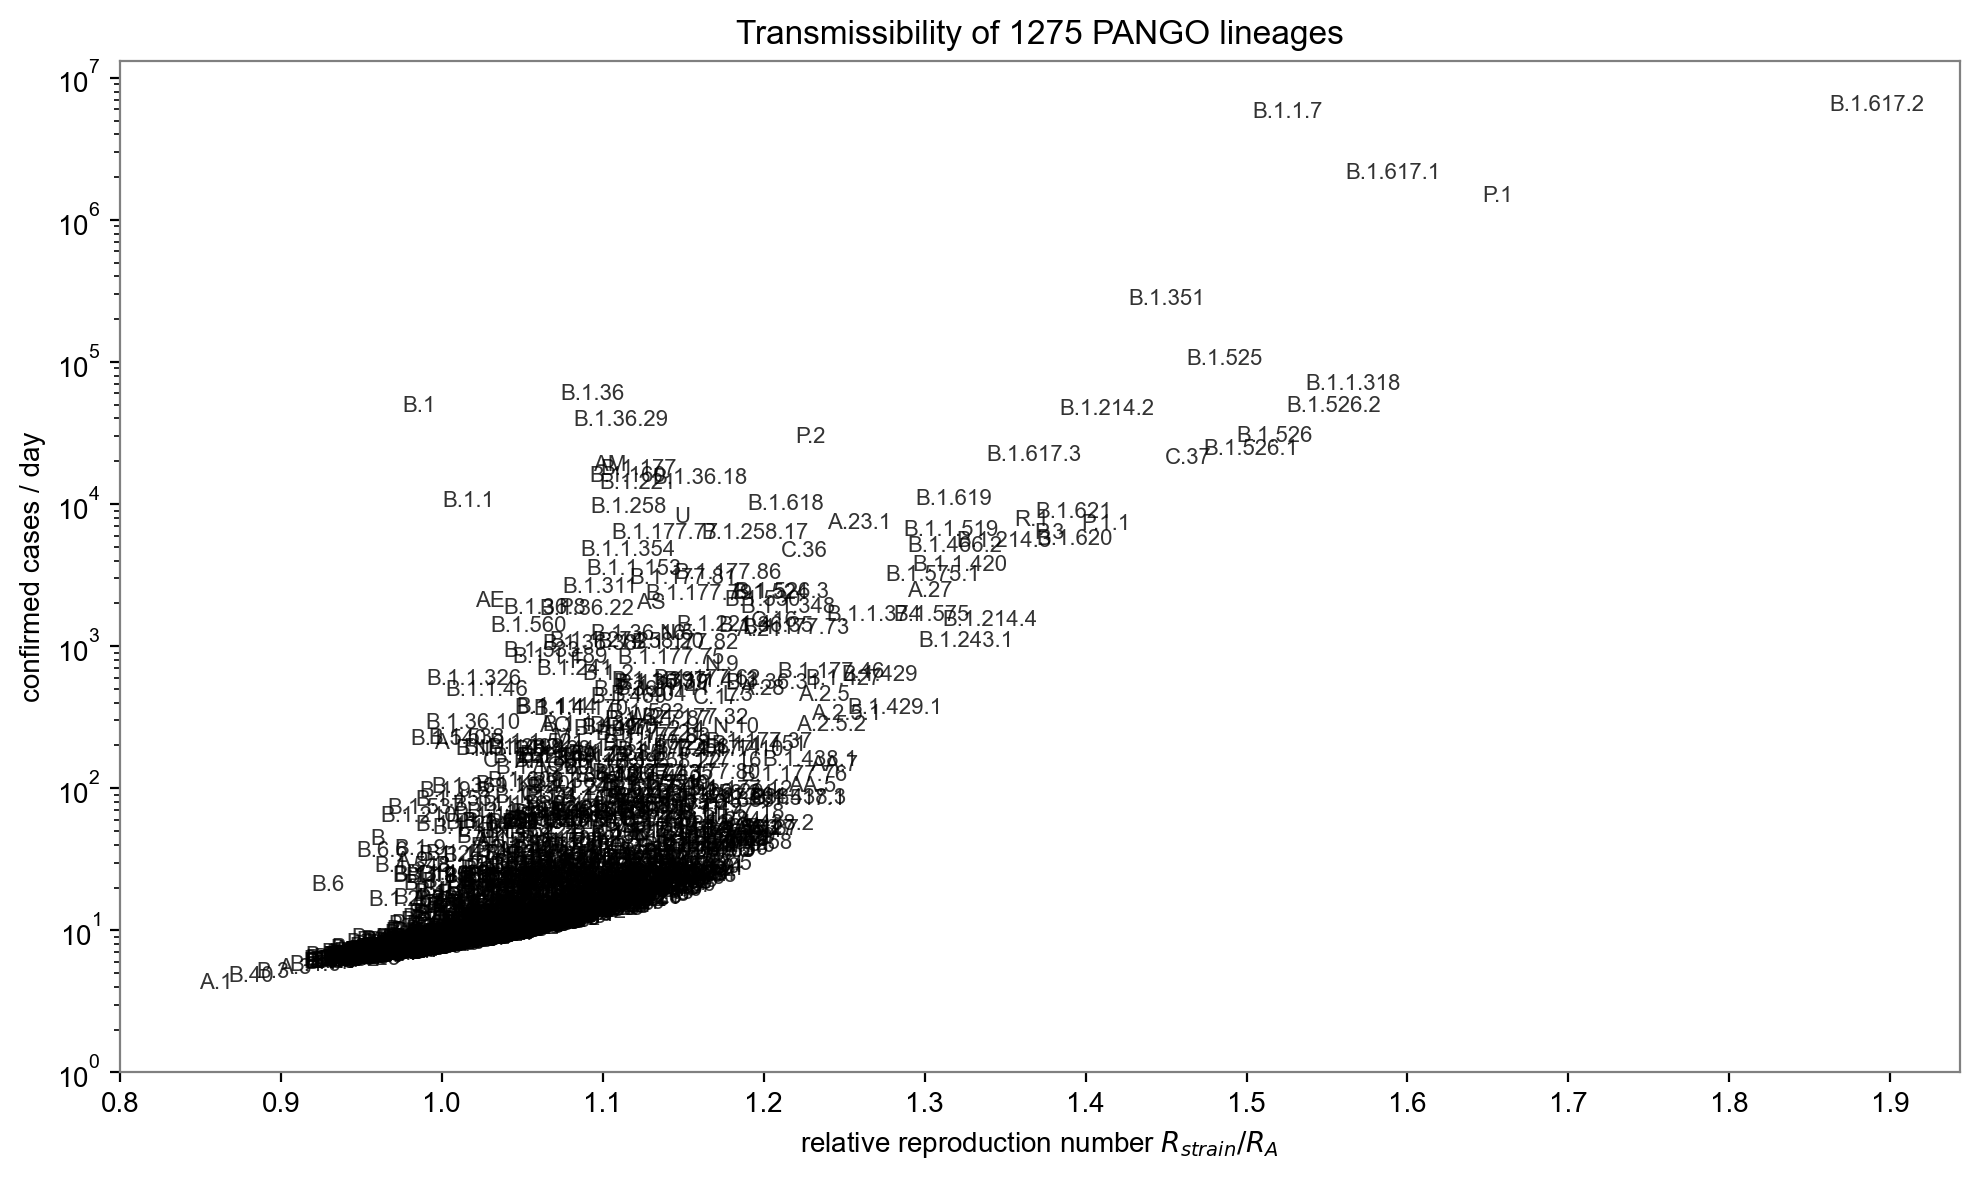

In [147]:
def plot_prevalence(fit, filenames=()):
    rate = fit["median"]["rate_coef"] @ features.T
    rate = rate - rate[lineage_id["A"]]
    R = rate.exp()
    init = fit["median"]["init"] + dataset["local_time"][-2, :, None] * rate
    init = init - init.logsumexp(-1, True)
    cases = torch.einsum("ps,p->s", init.exp(), weekly_cases[-2])
    cases = cases / mutrans.TIMESTEP
    plt.figure(figsize=(10, 6))
    plt.scatter(R, cases, lw=0, alpha=0)
    for name, i in lineage_id.items():
        if cases[i] <= 1.1:
            continue
        plt.text(R[i], cases[i], name, fontsize=8, alpha=0.8,
                 horizontalalignment="center", verticalalignment="center",)
    plt.ylabel("confirmed cases / day")
    plt.yscale("log")
    #plt.xscale("log")
    plt.ylim(1, None)
    plt.xlim(0.9, None)
    lb10 = math.floor(10 * R.min().item())
    ub10 = math.ceil(10 * R.max().item())
    xticks = [x10 / 10 for x10 in range(lb10, ub10 + 1)]
    plt.xticks(xticks, list(map(str, xticks)))
    plt.xlabel("relative reproduction number $R_{strain} / R_A$")
    plt.title(f"Transmissibility of {len(lineage_id)} PANGO lineages")
    plt.tight_layout()
    for filename in filenames:
        plt.savefig(filename)

plot_prevalence(mcmc_fit, ["paper/strain_prevalence.png"])

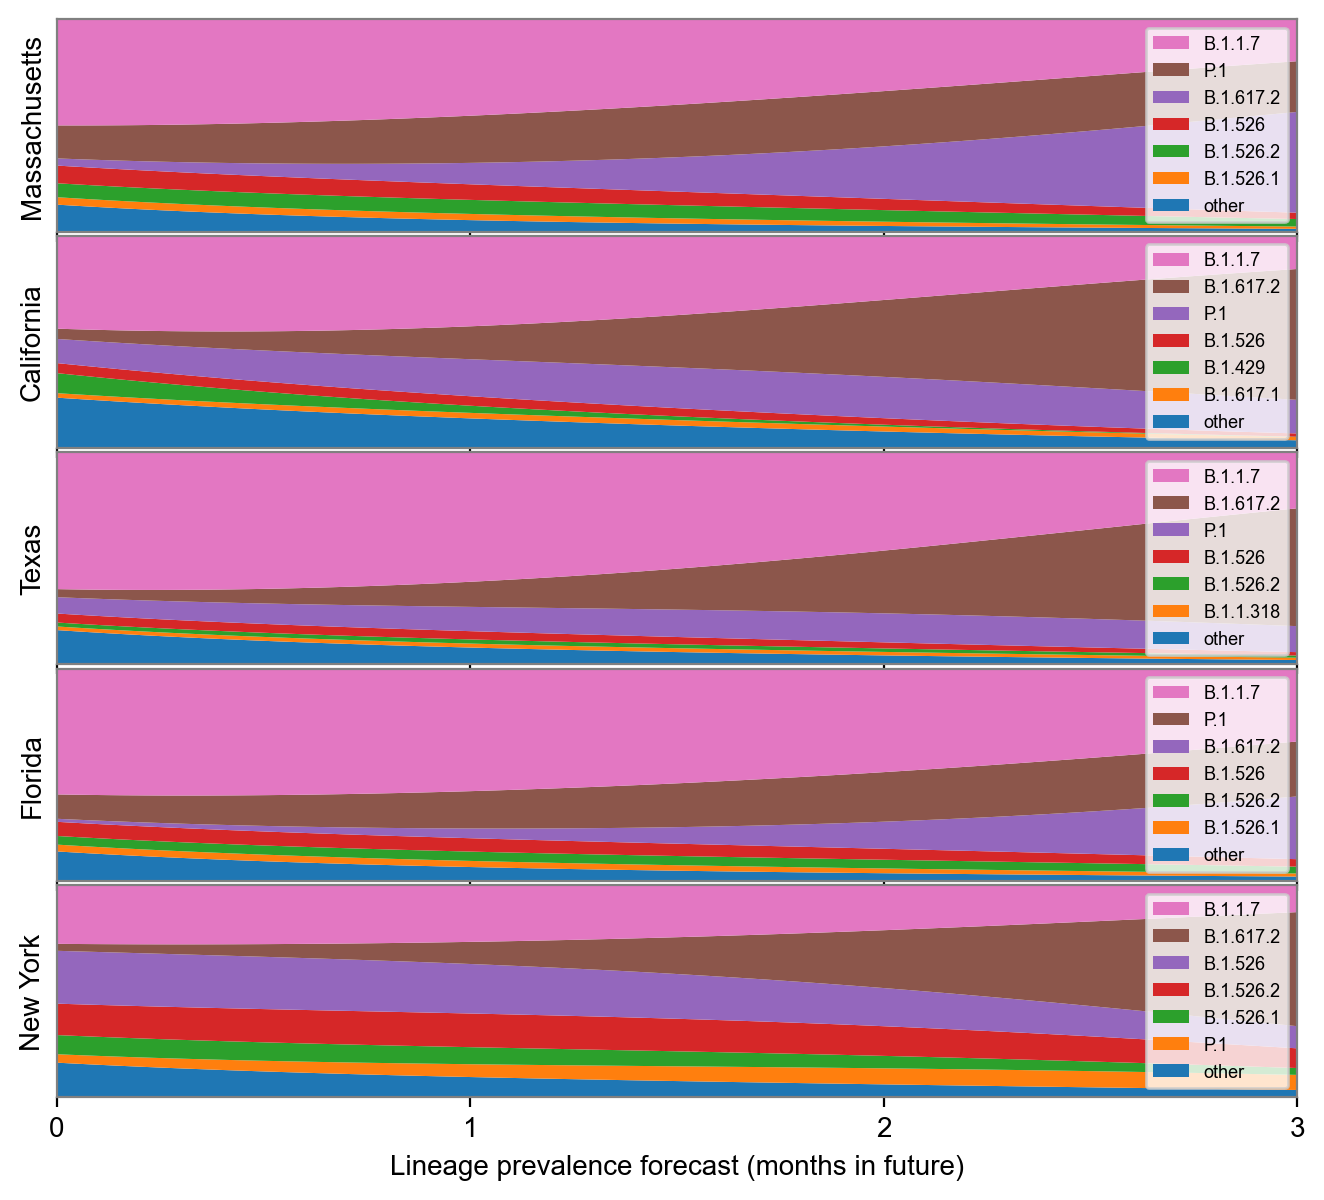

In [163]:
def plot_decomposition(median, queries, num_parts=7, months_ahead=3):
    if isinstance(queries, str):
        queries = [queries]
    fig, axes = plt.subplots(len(queries), figsize=(8, 1 + 1.2 * len(queries)), sharex=True)
    for row, (place_query, ax) in enumerate(zip(queries, axes)):
        names = [name for name, i in location_id.items() if place_query in name]
        assert len(names) == 1, place_query
        id_ = location_id[names[0]]
        rate = median["rate"]
        # FIXME this ignores region population when aggregating:
        init = median["init"][id_]
        assert init.shape == rate.shape
        time = torch.linspace(0, months_ahead / 12.0 * 365.25 / 5.5, 100)
        local_time = time + dataset["local_time"][-1, id_]
        portion = (init + rate * local_time[:, None]).softmax(-1)

        # Aggregate into top + others.
        best = portion.sum(0).sort(0, descending=True).indices
        parts = {"other": None}
        for i in range(num_parts - 1):
            i = best[num_parts - i - 2].item()
            parts[lineage_id_inv[i]] = portion[:, i].clone()
            portion[:, i] = 0
        parts["other"] = portion.sum(-1)
        months = time * 5.5 / 365.25 * 12

        ax.stackplot(months, *parts.values(), labels=tuple(parts))
        ax.set_xlim(months.min(), months.max())
        ax.set_xticks((0, 1, 2, 3))
        ax.set_ylim(0, 1)
        ax.set_yticks(())
        ax.set_ylabel(names[0].split("/")[-1].strip() if len(names) == 1 else place_query)
        if row == len(axes) - 1:
            ax.set_xlabel("Lineage prevalence forecast (months in future)")
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], loc="lower right", prop={"size": 6.5})
    plt.subplots_adjust(hspace=0.02);

plot_decomposition(mcmc_fit["median"],
                   ["Massachusetts", "California", "Texas", "Florida", "New York"])

## Extracting a table of top mutations and their stories

In [149]:
def rank_mutations(fit, names):
    mean = fit["mean"]["rate_coef"]
    sigma = mean / fit["std"]["rate_coef"].clamp(min=1e-8)
    ranks = sigma.sort(0, descending=True).indices.tolist()
    assert len(ranks) == len(mutations)
    ranked = [mutations[k] for k in ranks]
    ranks = {m: i for i, m in enumerate(ranked)}
    for name in names:
        print("{}\t{}".format(name, ranks[name]))

print("SVI:")
rank_mutations(svi_fit, ["S:D614G", "S:N501Y", "S:E484K", "S:L452R"])
print("MCMC:")
rank_mutations(mcmc_fit, ["S:D614G", "S:N501Y", "S:E484K", "S:L452R"])

SVI:
S:D614G	1605
S:N501Y	233
S:E484K	50
S:L452R	19
MCMC:
S:D614G	2091
S:N501Y	142
S:E484K	29
S:L452R	3


In [150]:
parent_features = torch.zeros_like(features)
for c, child in enumerate(lineage_id_inv):
    child = pangolin.decompress(child)
    parent = child
    while True:
        parent = "A" if parent == "A" else pangolin.get_parent(parent)
        try:
            p = lineage_id[pangolin.compress(parent)]
            break
        except KeyError:
            continue
    parent_features[c] = features[p]

In [151]:
def find_emergences(i):
    delta = features[:, i] - parent_features[:, i]
    emerged = set((delta > 0.5).nonzero(as_tuple=True)[0].tolist())
    emerged.add(delta.argmax().item())
    result = []
    for k in sorted(emerged):
        name = lineage_id_inv[k]
        longname = pangolin.decompress(name)
        result.append(name if name == longname else f"{name} ({longname})")
    return result

In [152]:
def write_mutation_table(fit, filename):
    assert filename.endswith(".tsv")
    mean = fit["mean"]["rate_coef"] / 100
    sigma = mean / fit["std"]["rate_coef"].clamp(min=1e-8)
    lb, ub = stats.confidence_interval(0.95, fit["samples"]["rate_coef"])
    R_RA = mean.exp()  # mean is in units of generation time.
    lineage_counts = weekly_strains.sum((0, 1))
    schema = [
        ("rank", "{:d}"),
        ("mutation", "{:s}"),
        ("mean/stddev", "{:0.6g}"),
        ("mean", "{:0.6g}"),
        ("95% ci lower", "{:0.6g}"),
        ("95% ci upper", "{:0.6g}"),
        ("R / R_A", "{:0.6g}"),
        ("emerged in lineages", "{:s}"),  
    ]
    header = "\t".join(h for h, r in schema) + "\n"
    row = "\t".join(r for h, r in schema) + "\n"
    with open(filename, "wt") as f:
        f.write(header)
        for rank, i in enumerate(sigma.sort(0, descending=True).indices.tolist()):
            emerged = find_emergences(i)
            f.write(row.format(
                rank + 1, mutations[i],
                sigma[i], mean[i], lb[i], ub[i], R_RA[i], ", ".join(emerged)
            ))

write_mutation_table(mcmc_fit, "paper/mutations.tsv")
pd.read_csv("paper/mutations.tsv", sep="\t")

rank      mutation  mean/stddev      mean  95% ci lower  95% ci upper  \
0        1       S:A222V     1.027780  0.000750      0.073530      0.076344   
1        2       N:S194L     0.903928  0.000486      0.047518      0.049623   
2        3       N:A220V     0.806686  0.000620      0.060502      0.063489   
3        4       S:L452R     0.757871  0.000845      0.082282      0.086658   
4        5       N:M234I     0.736335  0.000630      0.061359      0.064608   
...    ...           ...          ...       ...           ...           ...   
2246  2247       N:A208S    -0.392142 -0.000978     -0.102616     -0.093004   
2247  2248   ORF1a:V378I    -0.423604 -0.000694     -0.072644     -0.066255   
2248  2249   ORF1a:G392D    -0.458896 -0.000862     -0.089926     -0.082641   
2249  2250  ORF1b:Y1464C    -0.494257 -0.000893     -0.092639     -0.085660   
2250  2251  ORF1a:L1748M    -0.670632 -0.001718     -0.176667     -0.166998   

       R / R_A                                emerged in lineages  
0     1.000750                     B.1.160.30, B.1.177, B.1.36.31  
1     1.000490  B.1.1.298, B.1.116, B.1.169, B.1.184, B.1.188,...  
2     1.000620       B.1.160.30, B.1.177, B.1.423, B.1.562, B.4.8  
3     1.000850  A.2.5, A.21, A.27, C.16 (B.1.1.1.16), C.17 (B....  
4     1.000630  A.2.5, C.23 (B.1.1.1.23), B.1.1.214, P.2 (B.1....  
...        ...                                                ...  
2246  0.999023                                          B.1.1.456  
2247  0.999307                                                B.4  
2248  0.999138                                                B.3  
2249  0.999107                                                A.1  
2250  0.998283                                            B.1.235  

[2251 rows x 8 columns]

In [153]:
print(columns.keys())

dict_keys(['lineage', 'virus_name', 'accession_id', 'collection_date', 'location', 'add_location', 'day'])


In [154]:
def estimate_lineage_bdays(exclude_first=10):
    lineage_days = defaultdict(list)
    for lineage, day in zip(columns["lineage"], columns["day"]):
        lineage = pangolin.decompress(lineage)
        lineage_days[lineage].append(day)
    lineage_bday = {}
    for lineage, days in list(lineage_days.items()):
        days.sort()
        lineage_bday[lineage] = days[min(exclude_first, len(days) // 10)]
    start_date = datetime.datetime.strptime(mutrans.START_DATE, "%Y-%m-%d")
    return {
        lineage: (start_date + datetime.timedelta(days=day)).strftime("%Y-%m-%d")
        for lineage, day in lineage_bday.items()
    }

lineage_bday = estimate_lineage_bdays()

In [155]:
def write_strain_table(svi_fit, mcmc_fit, filename):
    assert filename.endswith(".tsv")
    R_mean = mcmc_fit["mean"]["rate"].exp()
    R_sample = mcmc_fit["samples"]["rate"].exp()
    RA = R_mean[lineage_id["A"]].item()
    R_RA = R_mean / RA
    lb, ub = stats.confidence_interval(0.95, R_sample / RA)
    logits = svi_fit["median"]["init"] + dataset["local_time"][..., None] * svi_fit["median"]["rate"]
    probs = (logits - logits.logsumexp(-1, True)).exp()
    cases = torch.einsum("tps,tp->ts", probs, weekly_cases)
    cases_per_day = cases[-2] / mutrans.TIMESTEP
    cases_total = cases.sum(0)
    schema = [
        ("rank", "{:d}"),
        ("strain", "{:s}"),
        ("R / R_A", "{:.6g}"),
        ("95% ci lower", "{:.6g}"),
        ("95% ci upper", "{:.6g}"),
        ("confirmed cases / day", "{:.6g}"),
        ("confirmed cases total", "{:.6g}"),
        ("birthday", "{:s}"),
    ]
    header = "\t".join(h for h, r in schema) + "\n"
    row = "\t".join(r for h, r in schema) + "\n"
    with open(filename, "wt") as f:
        f.write(header)
        for rank, i in enumerate(R_RA.sort(0, descending=True).indices.tolist()):
            lineage = lineage_id_inv[i]
            f.write(row.format(
                rank + 1, lineage,
                R_RA[i], lb[i], ub[i], cases_per_day[i], cases_total[i],
                lineage_bday[pangolin.decompress(lineage)],
            ))

write_strain_table(svi_fit, mcmc_fit, "paper/strains.tsv")
pd.read_csv("paper/strains.tsv", sep="\t")

rank     strain   R / R_A  95% ci lower  95% ci upper  \
0        1  B.1.617.2  1.891820      1.878990      1.904290   
1        2        P.1  1.655410      1.647560      1.663540   
2        3  B.1.617.1  1.591460      1.580510      1.603900   
3        4  B.1.1.318  1.565890      1.551070      1.580610   
4        5  B.1.526.2  1.554030      1.540300      1.566900   
...    ...        ...       ...           ...           ...   
1270  1271      B.4.6  0.921519      0.917647      0.925439   
1271  1272        A.3  0.908767      0.903199      0.914704   
1272  1273        B.3  0.895263      0.891363      0.899114   
1273  1274       B.40  0.881465      0.877589      0.885080   
1274  1275        A.1  0.859748      0.856410      0.863370   

      confirmed cases / day  confirmed cases total    birthday  
0              5.372410e+06            270454000.0  2021-02-27  
1              1.678960e+06            148167000.0  2020-12-16  
2              2.215430e+06             76867700.0  2021-01-03  
3              9.556720e+04              6270020.0  2021-01-25  
4              6.950250e+04              4773020.0  2021-01-01  
...                     ...                    ...         ...  
1270           6.175250e+00               872267.0  2020-03-03  
1271           5.808280e+00              1424560.0  2020-03-13  
1272           5.397790e+00              2914770.0  2020-02-27  
1273           5.085510e+00              4630880.0  2020-02-16  
1274           4.534870e+00             14019900.0  2020-02-26  

[1275 rows x 8 columns]

In [99]:
svi_fit["mean"].keys()

dict_keys(['feature_scale', 'rate_coef', 'rate', 'concentration'])

## Comparison with deep mutational scans

We first compare with [(Starr et al. 2020)](https://www.sciencedirect.com/science/article/pii/S0092867420310035) who study S mutations affecting folding and ACE2 binding.

In [100]:
df = pd.read_csv("data/mutation-studies/1-s2.0-S0092867420310035-mmc2.csv")
df

site_RBD  site_SARS2 wildtype mutant mutation mutation_RBD  bind_lib1  \
0            1         331        N      A    N331A          N1A      -0.05   
1            1         331        N      C    N331C          N1C      -0.08   
2            1         331        N      D    N331D          N1D       0.00   
3            1         331        N      E    N331E          N1E       0.02   
4            1         331        N      F    N331F          N1F      -0.03   
...        ...         ...      ...    ...      ...          ...        ...   
4216       201         531        T      T    T531T        T201T       0.00   
4217       201         531        T      V    T531V        T201V       0.03   
4218       201         531        T      W    T531W        T201W       0.02   
4219       201         531        T      Y    T531Y        T201Y       0.00   
4220       201         531        T      *    T531*        T201*        NaN   

      bind_lib2  bind_avg  expr_lib1  expr_lib2  expr_avg  
0         -0.02     -0.03      -0.14      -0.08     -0.11  
1         -0.10     -0.09      -1.56      -0.97     -1.26  
2          0.07      0.03      -0.75      -0.12     -0.44  
3         -0.02      0.00      -0.39      -0.24     -0.31  
4         -0.16     -0.10      -0.83      -0.57     -0.70  
...         ...       ...        ...        ...       ...  
4216       0.00      0.00       0.00       0.00      0.00  
4217      -0.02      0.01      -0.07      -0.05     -0.06  
4218      -0.06     -0.02      -0.13      -0.04     -0.08  
4219      -0.03     -0.01      -0.03      -0.08     -0.05  
4220        NaN       NaN      -4.59      -4.51     -4.55  

[4221 rows x 12 columns]

In [101]:
folding = {f"S:{m}": float(e) for m, e in zip(df["mutation"], df["expr_avg"])}
binding = {f"S:{m}": float(b) for m, b in zip(df["mutation"], df["bind_avg"])}
print(sum(1 for m in mutations if m in folding))

37


We next compare with [(Greaney et al. 2021)](https://www.sciencedirect.com/science/article/pii/S1931312820306247) who study antibody escape.

In [102]:
df = pd.read_csv("data/mutation-studies/1-s2.0-S1931312820306247-mmc2.csv")
df

condition  site wildtype mutation  mut_escape  site_total_escape  \
0      COV2-2050   331        N        A    0.000366            0.03350   
1      COV2-2050   331        N        C    0.001012            0.03350   
2      COV2-2050   331        N        D    0.000373            0.03350   
3      COV2-2050   331        N        E    0.005233            0.03350   
4      COV2-2050   331        N        F    0.001505            0.03350   
...          ...   ...      ...      ...         ...                ...   
23591    rCR3022   531        T        R    0.004248            0.08231   
23592    rCR3022   531        T        S    0.003195            0.08231   
23593    rCR3022   531        T        V    0.004409            0.08231   
23594    rCR3022   531        T        W    0.005216            0.08231   
23595    rCR3022   531        T        Y    0.003794            0.08231   

       site_max_escape  
0             0.005233  
1             0.005233  
2             0.005233  
3             0.005233  
4             0.005233  
...                ...  
23591         0.006145  
23592         0.006145  
23593         0.006145  
23594         0.006145  
23595         0.006145  

[23596 rows x 7 columns]

In [103]:
escape = {
    f"S:{w}{s}{m}": float(e)
    for w, s, m, e in zip(df["wildtype"], df["site"], df["mutation"], df["mut_escape"])
}
print(sum(1 for m in mutations if m in escape))

37


In [104]:
def correlation(x, y):
    x = (x - x.mean()) / x.std()
    y = (y - x.mean()) / y.std()
    return (x * y).mean()

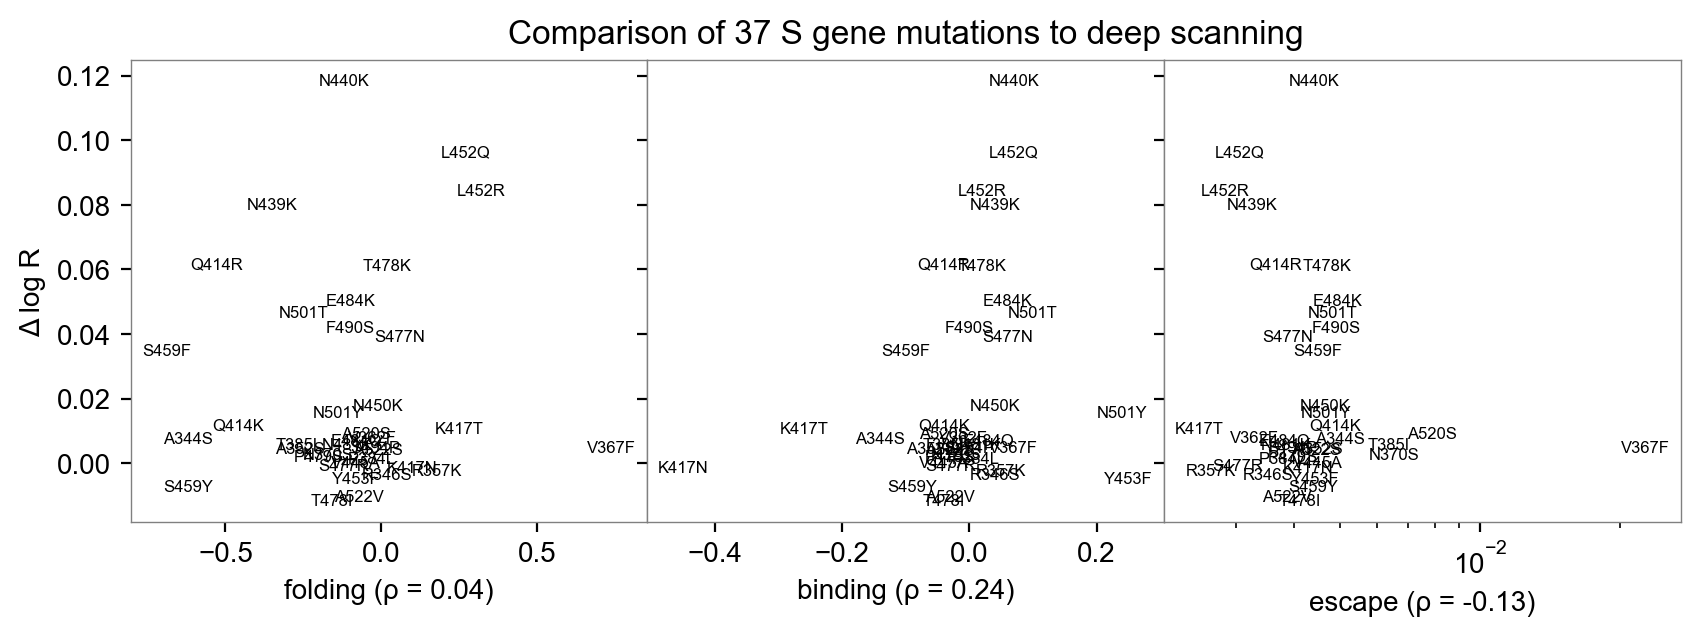

In [105]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
ms = [m for m in mutations if m in escape]
y = mcmc_fit["mean"]["rate_coef"][[i for i, m in enumerate(mutations) if m in escape]].numpy()
axes[0].set_ylabel("Δ log R")
for name, ax in zip(["folding", "binding", "escape"], axes):
    scan = locals()[name]
    x = torch.tensor([scan[m] for m in ms]).numpy()
    # ax.scatter(x, y, alpha=0.5, lw=0)
    for xm, ym, m in zip(x, y, ms):
        ax.text(xm, ym, m[2:], fontsize=6,
                verticalalignment="center", horizontalalignment="center")
    ax.set_xlim(1.08 * x.min() - 0.08 * x.max(), 1.08 * x.max() - 0.08 * x.min())
    ax.set_ylim(1.05 * y.min() - 0.05 * y.max(), 1.05 * y.max() - 0.05 * y.min())
    ax.set_xlabel(f"{name} (ρ = {correlation(x, y):0.2g})")
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
axes[2].set_xscale("log")
axes[2].set_xlim(x.min() ** 1.08 / x.max() ** 0.08, x.max() ** 1.08 / x.min() ** 0.08)
axes[1].set_title(f"Comparison of {len(ms)} S gene mutations to deep scanning")
plt.subplots_adjust(wspace=0)

It's hard to say whether these correlations are meaningful, as they are dominated by a few outliers.

Let's fit a linear model regressing transmissibility against theses deep scanning results.

In [106]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoMultivariateNormal
from pyro.optim import Adam

def fit_model(fit):
    trans_data = fit["mean"]["rate_coef"][[i for i, m in enumerate(mutations) if m in escape]]
    folding_data = torch.tensor([folding[m] for m in ms])
    binding_data = torch.tensor([binding[m] for m in ms])
    escape_data = torch.tensor([escape[m] for m in ms])
    
    def model():
        coef = pyro.sample("coef", dist.Normal(0, 10).expand([5]).to_event(1))
        t, f, b, e, be = coef.unbind(-1)
        noise = pyro.sample("noise", dist.LogNormal(0, 2))
        with pyro.plate("data", len(trans_data)):
            pred = (
                t + f * folding_data + b * binding_data + e * escape_data
                + be * binding_data * escape_data
            )
            pyro.sample("trans", dist.Normal(pred, noise), obs=trans_data)

    pyro.clear_param_store()
    guide = AutoMultivariateNormal(model)
    elbo = Trace_ELBO(num_particles=100, vectorize_particles=True)
    svi = SVI(model, guide, Adam({"lr": 0.2}), elbo)
    for step in range(201):
        loss = svi.step()
        if step % 20 == 0:
            print(f"step {step} loss = {loss:0.4g}")
    loc, scale = guide._loc_scale()
    print("Model:")
    print("transmissibility = t + f folding + b binding + e escape + be binding escape")
    print("Learned coefficients:")
    for k, l, s in zip("t f b e be".split(), loc.tolist(), scale.tolist()):
        print(f"{k} = {l:0.4g} +- {s:0.2f}")
        
fit_model(mcmc_fit)

 17296199 Guessed max_plate_nesting = 2


step 0 loss = 337.6
step 20 loss = 104.3
step 40 loss = 80.17
step 60 loss = 45.53
step 80 loss = -0.2442
step 100 loss = -35.7
step 120 loss = -42.6
step 140 loss = -50.34
step 160 loss = -43.69
step 180 loss = -49.49
step 200 loss = -50.79
Model:
transmissibility = t + f folding + b binding + e escape + be binding escape
Learned coefficients:
t = 0.03376 +- 0.01
f = 0.01763 +- 0.02
b = 0.09586 +- 0.07
e = -1.882 +- 0.94
be = -0.3028 +- 7.34


## Fit on subsets of data

In [107]:
print(Counter([n for n in columns["virus_name"] if "-CDC-2-" in n]).most_common(2))
print(Counter([n for n in columns["location"] if "USA" in n]).most_common(2))
print(Counter([n for n in columns["location"] if "United King" in n]).most_common(2))

[('hCoV-19/USA/KS-CDC-2-3693594/2020', 1), ('hCoV-19/USA/KS-CDC-2-3693489/2020', 1)]
[('North America / USA / Texas / Houston', 25976), ('North America / USA / Florida', 22771)]
[('Europe / United Kingdom / England', 316448), ('Europe / United Kingdom / Scotland', 36773)]


In [108]:
holdout_fits = {k[-1]: v for k, v in fits.items() if k[-1] and k[0] == "mcmc"}
for key in holdout_fits:
    print(key[-1])

('include', (('location', '^North America / USA'),))
('exclude', (('location', '^North America / USA'),))


In [109]:
aliases = [
    "only the USA",
    "excluding the USA",
    # "excluding the UK",
    # "only the UK",
    # "only CDC data",
    # "only CDC NS3 data",
]
holdout_fits = dict(zip(aliases, holdout_fits.values()))

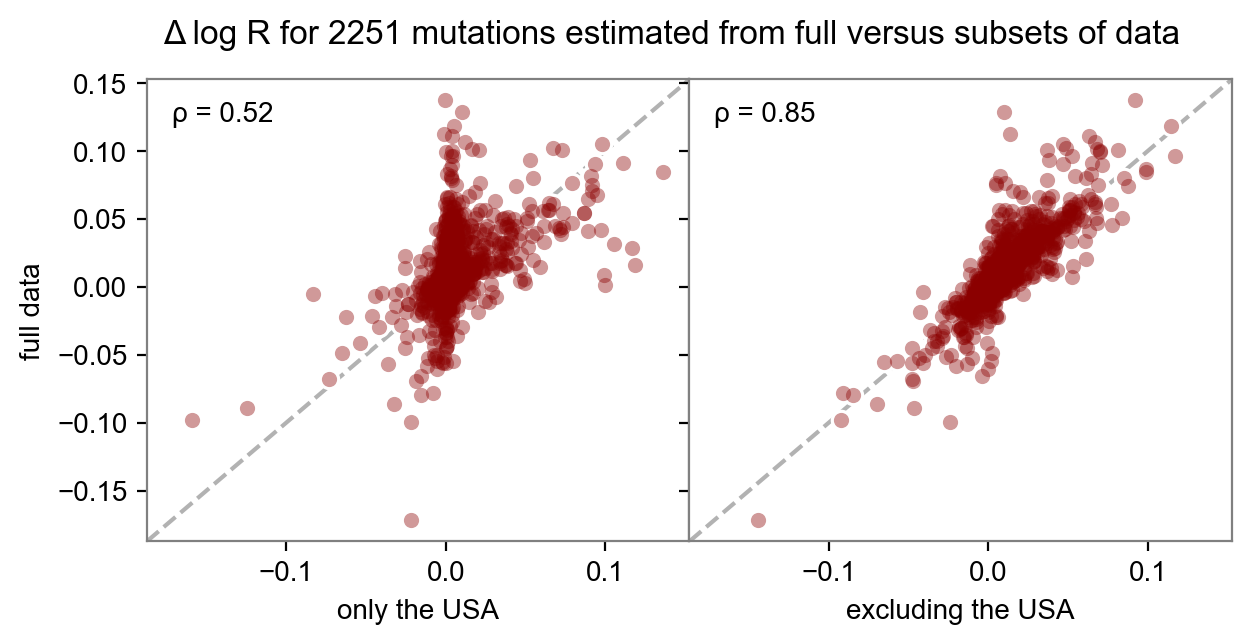

In [117]:
def plot_mutation_agreements(fit1, holdouts, filenames=()):
    def get_mean(fit):
        return fit["mean"]["rate_coef"]
    mean1 = get_mean(fit1)
    means = [get_mean(fit) for fit in holdouts.values()]
    x0 = min(mean.min().item() for mean in [mean1] + means)
    x1 = max(mean.max().item() for mean in [mean1] + means)
    lb = 1.05 * x0 - 0.05 * x1
    ub = 1.05 * x1 - 0.05 * x0
    fig, axes = plt.subplots(1, len(holdouts), figsize=(7, 3), sharey=True)
    fig.suptitle("Δ log R for {} mutations estimated from full versus subsets of data"
                 .format(len(fit1["mutations"])))
    for ax, (name, fit2), mean2 in zip(axes, holdouts.items(), means):
        mutations = sorted(set(fit1["mutations"]) & set(fit2["mutations"]))
        means = []
        for fit, mean in ((fit1, mean1), (fit2, mean2)):
            m_to_i = {m: i for i, m in enumerate(fit["mutations"])}
            idx = torch.tensor([m_to_i[m] for m in mutations])
            means.append(mean[idx])
        ax.plot([lb, ub], [lb, ub], 'k--', alpha=0.3, zorder=-100)
        ax.scatter(means[1].numpy(), means[0].numpy(), 60, alpha=1, lw=0, color="white")
        ax.scatter(means[1].numpy(), means[0].numpy(), 30, alpha=0.4, lw=0, color="darkred")
        ax.text(x0, 0.05 * x0 + 0.95 * x1,
                "ρ = {:0.2g}".format(correlation(means[0], means[1])))
        ax.set_xlim(lb, ub)
        ax.set_xlabel(name)
    axes[0].set_ylim(lb, ub)
    axes[0].set_ylabel("full data")
    plt.subplots_adjust(wspace=0)
    for f in filenames:
        plt.savefig(f)

plot_mutation_agreements(mcmc_fit, holdout_fits, ["paper/mutation_agreement.png"])

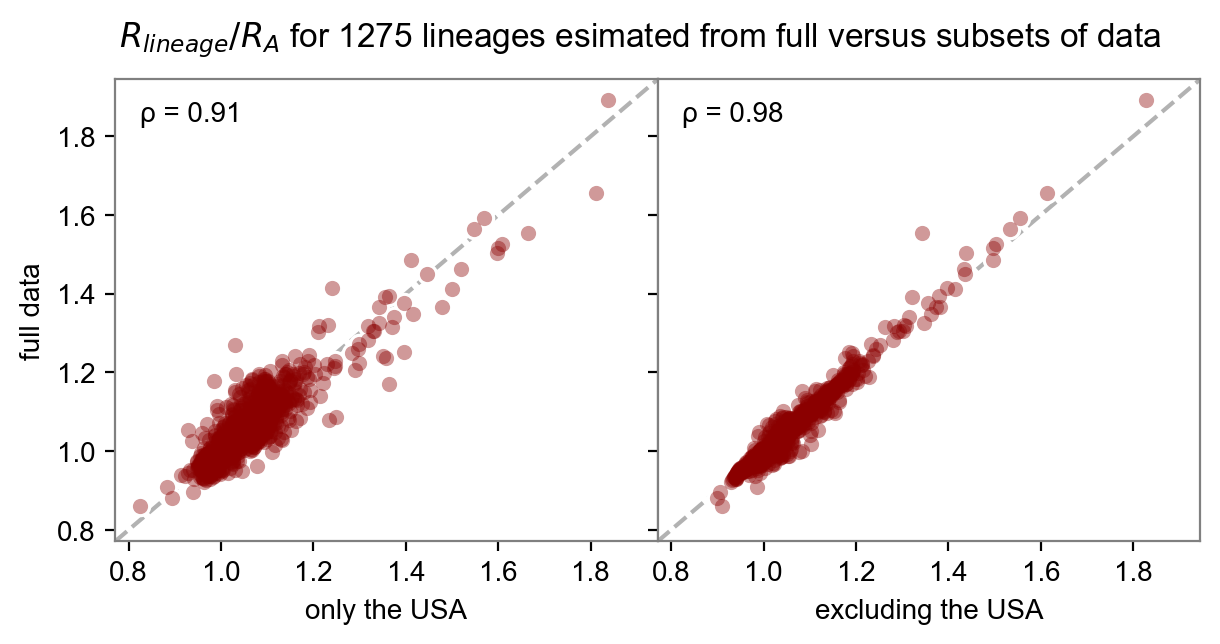

In [116]:
def plot_strain_agreements(fit1, holdouts, filenames=()):
    def get_mean(fit):
        rate = fit["median"]["rate"]
        return (rate - rate[lineage_id["A"]]).exp()
    mean1 = get_mean(fit1)
    means = [get_mean(fit) for fit in holdouts.values()]
    x0 = min(mean.min().item() for mean in [mean1] + means)
    x1 = max(mean.max().item() for mean in [mean1] + means)
    lb = 1.05 * x0 - 0.05 * x1
    ub = 1.05 * x1 - 0.05 * x0
    fig, axes = plt.subplots(1, len(holdouts), figsize=(7, 3), sharey=True)
    fig.suptitle("$R_{{lineage}} / R_A$ for {} lineages esimated from full versus subsets of data"
                 .format(len(lineage_id)))
    for ax, name, mean2 in zip(axes, holdouts, means):
        ax.plot([lb, ub], [lb, ub], 'k--', alpha=0.3, zorder=-100)
        ax.scatter(mean2.numpy(), mean1.numpy(), 60, alpha=1, lw=0, color="white")
        ax.scatter(mean2.numpy(), mean1.numpy(), 30, alpha=0.4, lw=0, color="darkred")
        ax.text(x0, 0.05 * x0 + 0.95 * x1,
                "ρ = {:0.2g}".format(correlation(mean1, mean2)))
        ax.set_xlim(lb, ub)
        ax.set_xlabel(name)
    axes[0].set_ylim(lb, ub)
    axes[0].set_ylabel("full data")
    plt.subplots_adjust(wspace=0)
    for f in filenames:
        plt.savefig(f)

plot_strain_agreements(mcmc_fit, holdout_fits, ["paper/lineage_agreement.png"])

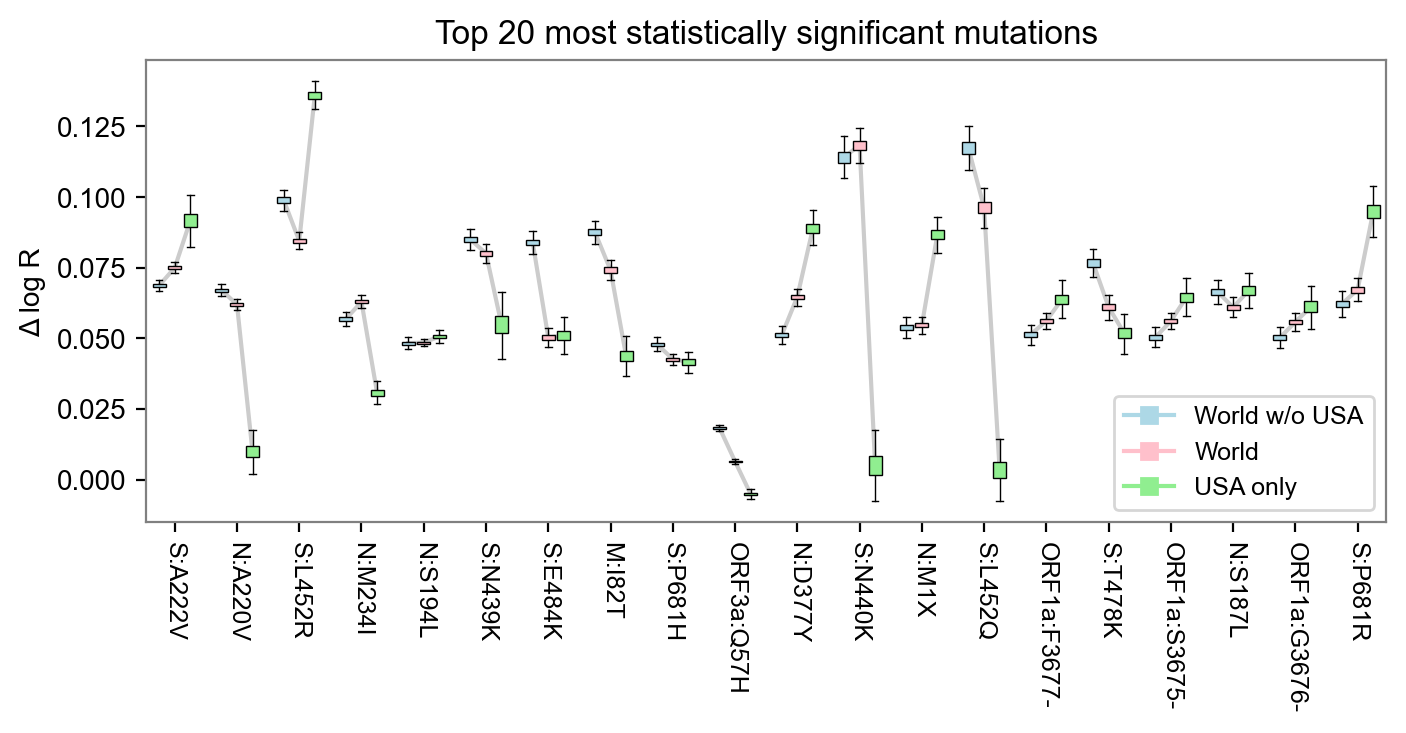

In [113]:
def plot_mutation_subset_boxplot(fits, rankby="s", top_k=20, filenames=()):
    best_fit = next(iter(fits.values()))
    if rankby == "s":
        rankby = best_fit["mean"]["rate_coef"] / best_fit["std"]["rate_coef"]
        title = f"Top {top_k} most statistically significant mutations"
    elif rankby == "t":
        rankby = best_fit["mean"]["rate_coef"]
        title = f"Top {top_k} most transmissible mutations"
    else: raise ValueError(rankby)
    top_indices = rankby.sort(0, descending=True).indices[:top_k]
    top_mutations = [mutations[i] for i in top_indices.tolist()]
    xscale = 0.6
    positions = (torch.arange(top_k)[:, None] * (len(fits) + 1)
                 + torch.arange(len(fits))).reshape(-1) * xscale
    data = [None] * top_k * len(fits)
    lines = [None] * top_k * (len(fits) + 1)
    for j, fit in enumerate(fits.values()):
        if "samples" in fit:
            samples = fit["samples"]["rate_coef"].T[top_indices].T
        else:
            mean = fit["mean"]["rate_coef"][top_indices]
            std = fit["std"]["rate_coef"][top_indices]
            samples = dist.Normal(mean, std).sample((1000,))
        for i in range(top_k):
            data[i * len(fits) + j] = samples[:, i]
            lines[i * (len(fits) + 1) + j] = samples[:, i].mean(0)
    xs = [None if y is None else i * xscale for i, y in enumerate(lines)]
    
    plt.figure(figsize=(8, 3))
    plt.plot(xs, lines, "k-", alpha=0.2)
    props = {"linewidth": 0.5}
    boxplot = plt.boxplot(data, positions=positions, vert=True, patch_artist=True,
                          showfliers=False,
                          boxprops=props, whiskerprops=props, capprops=props,
                          medianprops={"alpha": 0})
    colors = ['lightblue', 'pink', 'lightgreen']
    for i, patch in enumerate(boxplot['boxes']):
        patch.set_facecolor(colors[i % len(fits)])
    for name, c in zip(fits, colors):
        plt.plot([], label=name, marker="s", color=c)
    plt.legend(loc="best", prop={'size': 9})
    start = (len(fits) - 1) / 2
    plt.xticks(torch.linspace(start, start + (top_k - 1) * (len(fits) + 1), top_k) * xscale,
               # labels=[x.replace(":", ":\n") for x in top_mutations],
               labels=top_mutations, rotation=-90, fontsize=9)
    plt.ylabel("Δ log R")
    plt.title(title)
    for f in filenames:
        plt.savefig(f)

plot_mutation_subset_boxplot({
    "World w/o USA": holdout_fits['excluding the USA'],
    "World": mcmc_fit,
    "USA only": holdout_fits['only the USA'],
}, filenames=["paper/mutation_usa_boxplot.png"])
# plot_mutation_subset_boxplot({
#     "World w/o UK": holdout_fits['excluding the UK'],
#     "World": mcmc_fit,
#     "UK only": holdout_fits['only the UK'],
# }, filenames=["paper/mutation_uk_boxplot.png"])

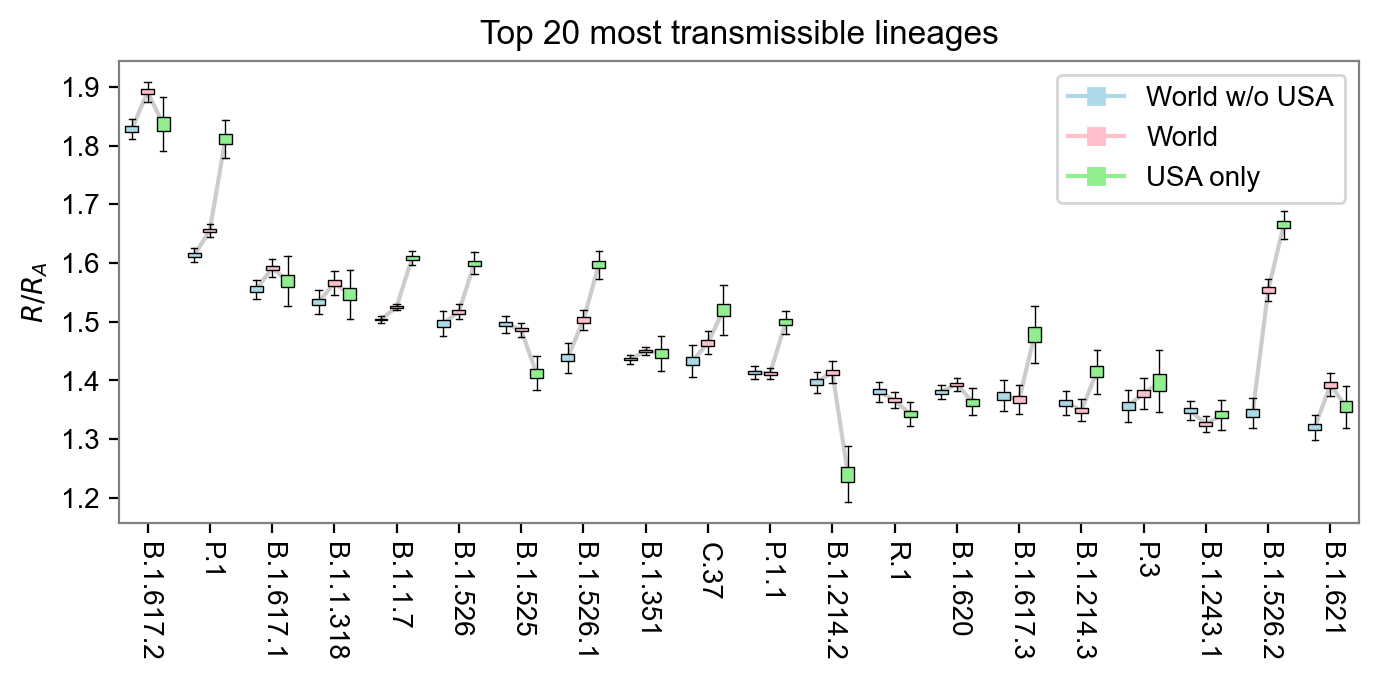

In [114]:
def plot_strain_subset_boxplot(fits, top_k=20, filenames=()):
    best_fit = next(iter(fits.values()))
    top_indices = best_fit["mean"]["rate"].sort(0, descending=True).indices[:top_k]
    top_lineages = [lineage_id_inv[i] for i in top_indices.tolist()]
    xscale = 0.6
    positions = (torch.arange(top_k)[:, None] * (len(fits) + 1)
                 + torch.arange(len(fits))).reshape(-1) * xscale
    data = [None] * top_k * len(fits)
    lines = [None] * top_k * (len(fits) + 1)
    for j, fit in enumerate(fits.values()):
        if "samples" in fit:
            samples = fit["samples"]["rate"].T[top_indices].T
        else:
            mean = fit["median"]["rate"][top_indices]
            std = fit["std"]["rate"][top_indices]
            samples = dist.Normal(mean, std).sample((1000,))
        samples = samples - fit["median"]["rate"][lineage_id["A"]]
        samples = samples.exp()
        for i in range(top_k):
            data[i * len(fits) + j] = samples[:, i]
            lines[i * (len(fits) + 1) + j] = samples[:, i].mean()
    xs = [None if y is None else i * xscale for i, y in enumerate(lines)]

    plt.figure(figsize=(8, 3))
    plt.plot(xs, lines, "k-", alpha=0.2)
    props = {"linewidth": 0.5}
    boxplot = plt.boxplot(data, positions=positions, vert=True, patch_artist=True,
                          showfliers=False,
                          boxprops=props, whiskerprops=props, capprops=props,
                          medianprops={"alpha": 0})
    colors = ['lightblue', 'pink', 'lightgreen']
    for i, patch in enumerate(boxplot['boxes']):
        patch.set_facecolor(colors[i % len(fits)])
    for name, c in zip(fits, colors):
        plt.plot([], label=name, marker="s", color=c)
    plt.legend(loc="best", prop={'size': 10})
    start = (len(fits) - 1) / 2
    plt.xticks(torch.linspace(start, start + (top_k - 1) * (len(fits) + 1), top_k) * xscale,
               labels=top_lineages, rotation=-90)
    plt.ylabel("$R / R_A$")
    plt.title(f"Top {top_k} most transmissible lineages")
    for f in filenames:
        plt.savefig(f)

plot_strain_subset_boxplot({
    "World w/o USA": holdout_fits['excluding the USA'],
    "World": mcmc_fit,
    "USA only": holdout_fits['only the USA'],
}, filenames=["paper/strain_usa_boxplot.png"])
# plot_strain_subset_boxplot({
#     "World w/o UK": holdout_fits['excluding the UK'],
#     "World": mcmc_fit,
#     "UK only": holdout_fits['only the UK'],
# }, filenames=["paper/strain_uk_boxplot.png"])